In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import keras


In [2]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import confusion_matrix, classification_report



In [3]:
from numba import jit , cuda


#### Project is divided into two cases 1. Detection of disease and 2. Classification of disease

## Detection of Disease

In [596]:
# Global variables
SAVE=False
SEED=111


# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['Disease', 'Healthy']
N_TYPES = len(CLASS_TYPES)

### Importing Data

In [597]:
# Function for inporting data           
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return data_path, data_labels

In [598]:
# Setting up file paths for training and testing
USER_PATH = r"C:\Users\anj1ban\OneDrive - Bosch Group\PersonalDrive\Thesis\Topic 2  parkinsons\dataset\PD classification\Detection"
train_dir = USER_PATH + r'/Training Data/'
test_dir = USER_PATH + r'/Testing Data/'

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 7791
Number of Labels: 7791

Testing
Number of Paths: 2548
Number of Labels: 2548


Training Counts
{'Disease': 4039, 'Healthy': 3752}

Testing Counts
{'Disease': 1320, 'Healthy': 1228}


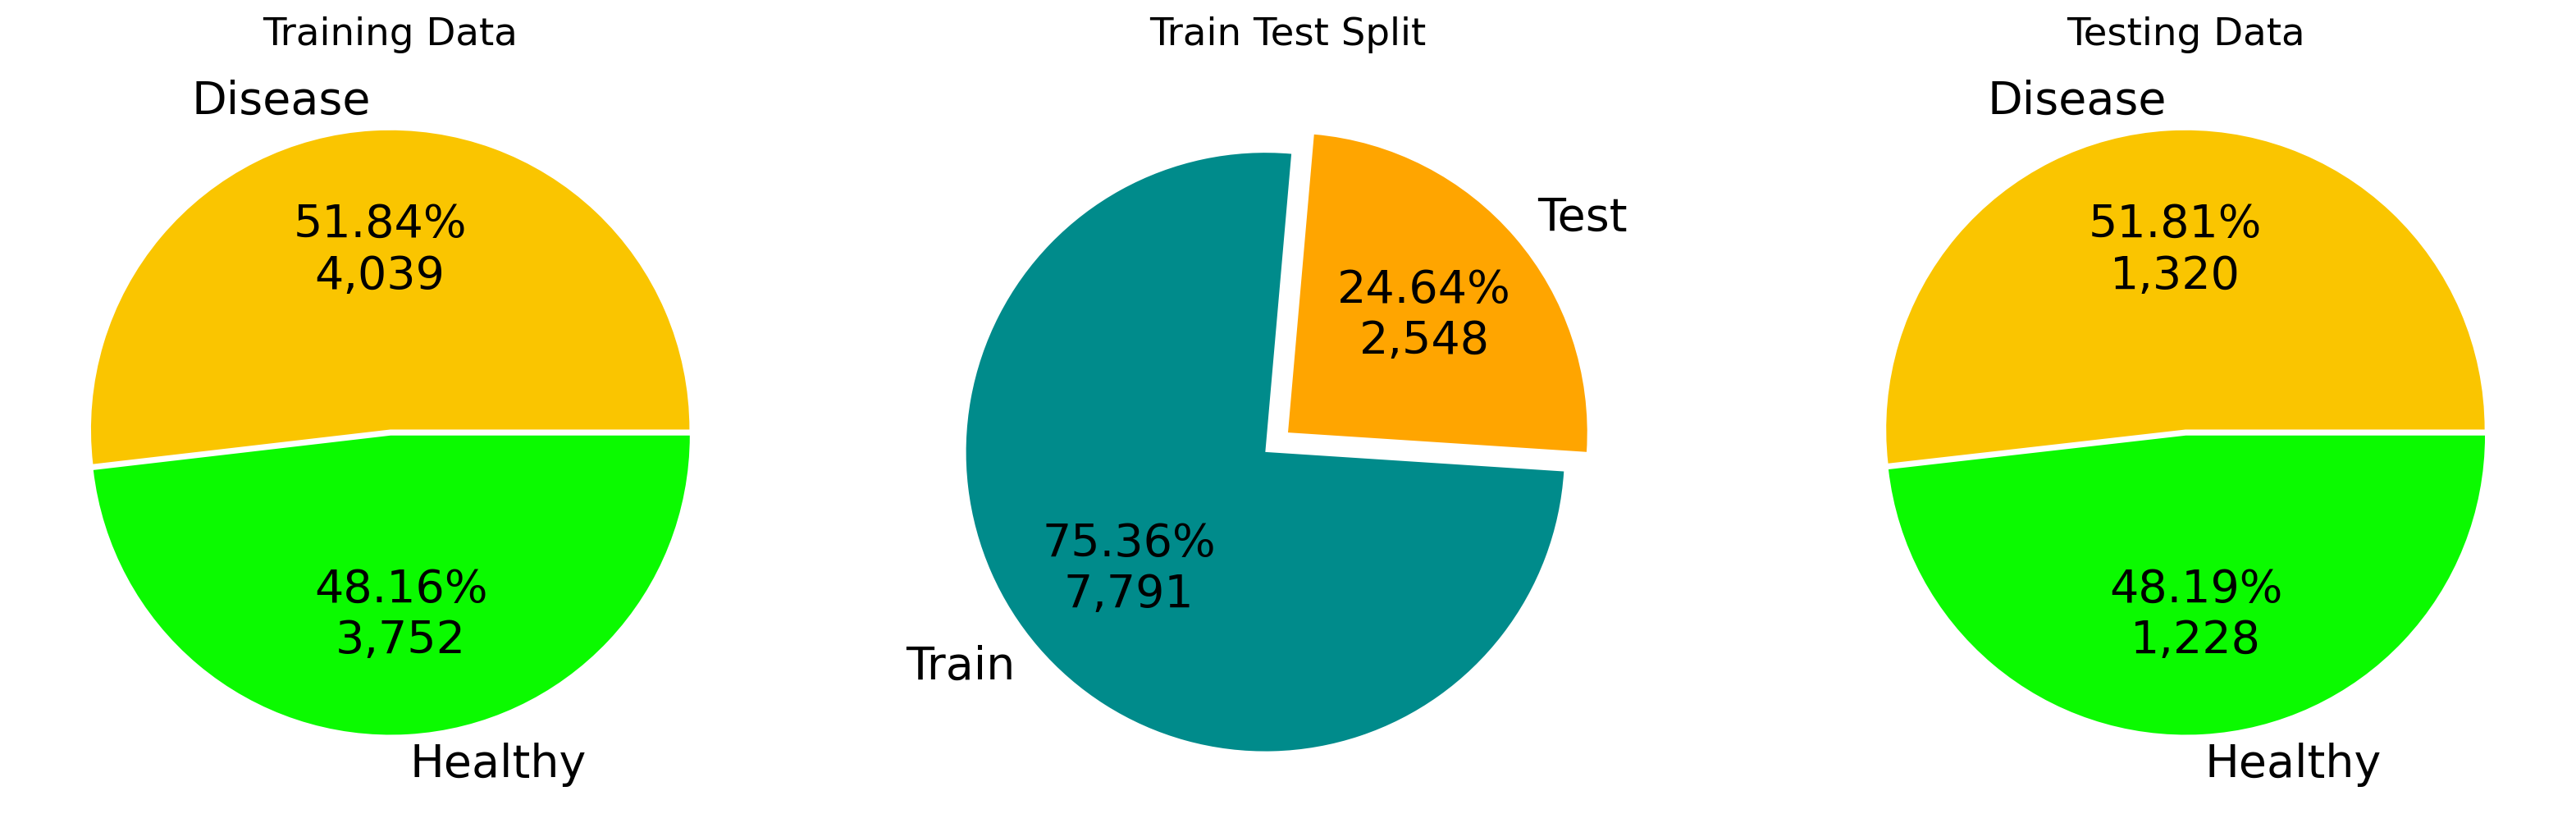

In [599]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
print('Training Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_labels), len(test_labels)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_labels), len(test_labels)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
print('\nTesting Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),  # Explode the slices slightly for better visualization
    textprops={'fontsize': 20}  # Set the font size for the text on the pie chart
)


plt.show()

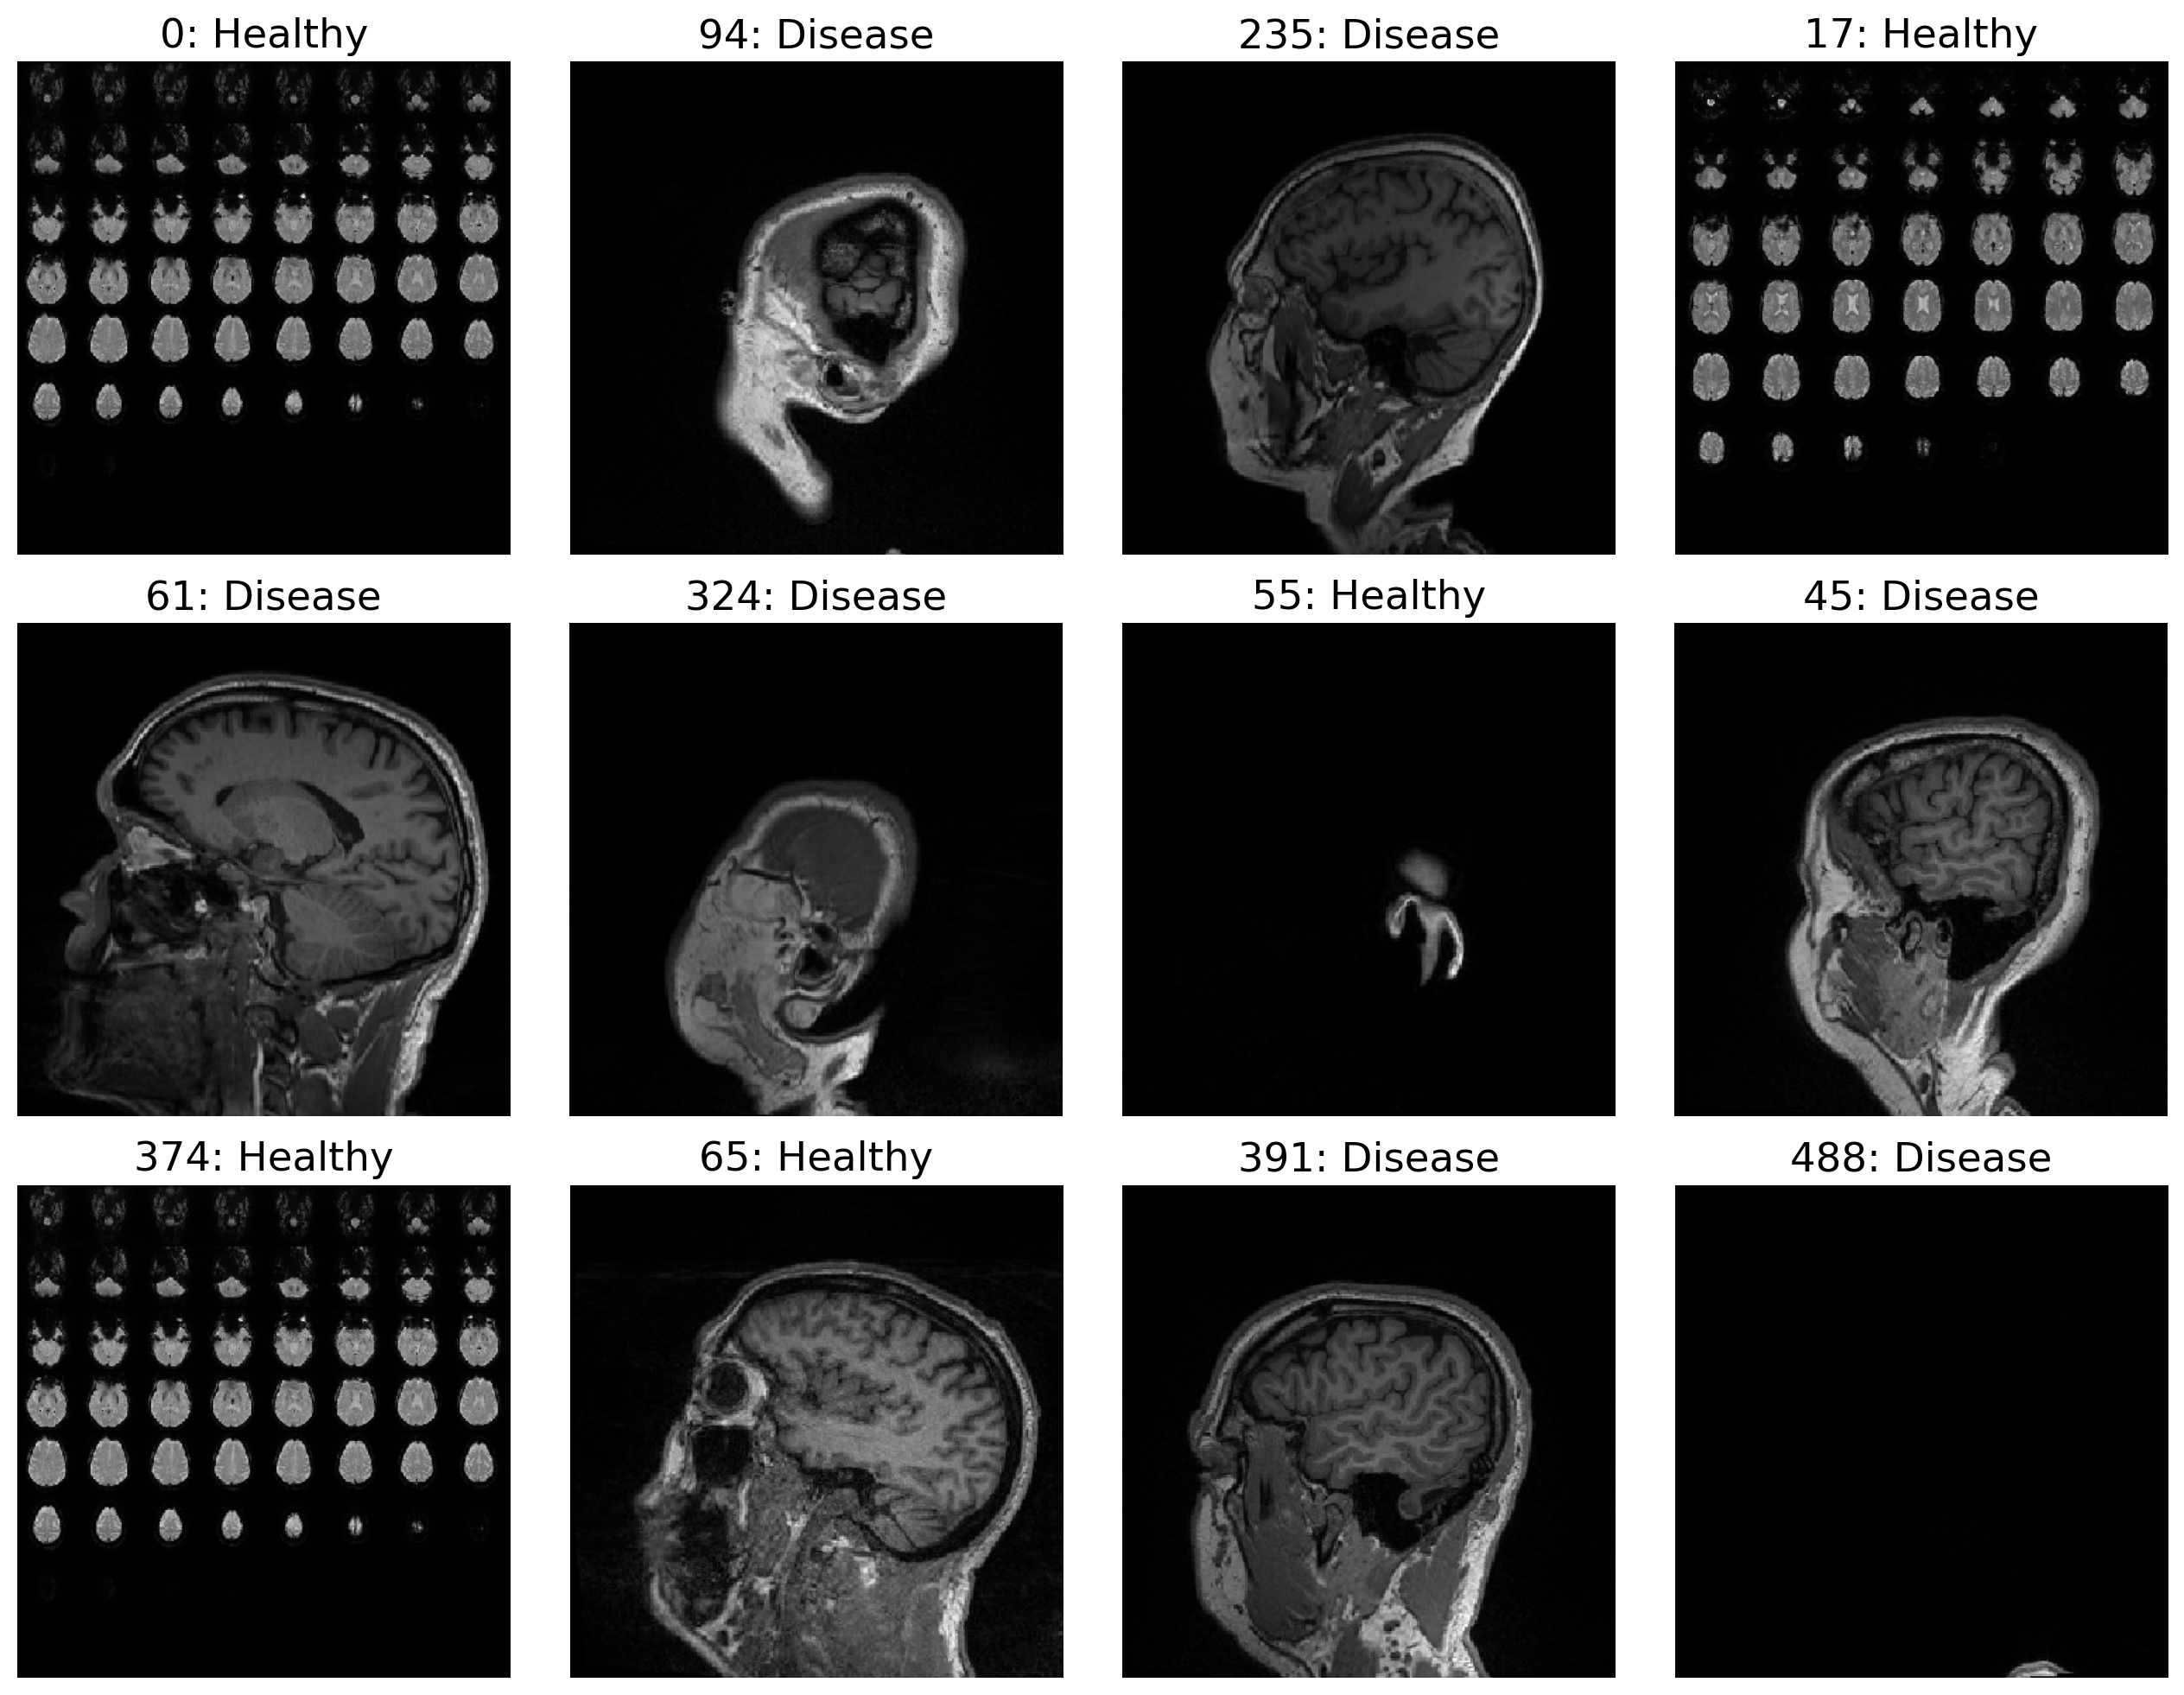

In [600]:
# Four different data classification images, from three different angles (images are independent)
show_images(train_paths, train_labels, im_size=350, figsize=(13,10),
            index_list=[0, 94, 235, 17,
                        61, 324, 55, 45,
                        374, 65, 391, 488])

### Output Image nad label Visualisation

In [601]:
# –––––––––––––––––––––––––––––––––––––– #
# Output Images and Labels Visualization #
# –––––––––––––––––––––––––––––––––––––– #
def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(12, 8)):
    """
    Nice display of prediction samples to see CNN predictions
    for classification.
    """
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)
    
    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")
        
        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)
        
    plt.tight_layout()
    plt.show()

    
# –––––––––––––––––––––––––––––––––––––– #
#            Confusion matrix            #
# –––––––––––––––––––––––––––––––––––––– #
def CM(CNN_model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    
    return confusion_matrix_array


# –––––––––––––––––––––––––––––––––––––– #
#             Metric Analysis            #
# –––––––––––––––––––––––––––––––––––––– #
def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")
        
    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")


### Conventional CNN Model

x reshaped: (1, 150, 150, 3)


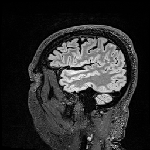

In [602]:
# getting image to test output
im = load_img(train_paths[200], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')


# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [603]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size_d = 40

### Data Processing and Training steup values

In [604]:
# Data augmentation and preprocessing
train_datagen_d = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator_d = train_datagen_d.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size_d,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen_d = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator_d = test_datagen_d.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size_d,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 7791 images belonging to 2 classes.
Found 2548 images belonging to 2 classes.


In [605]:
# Accessing class indices for training data generator
class_indices_train = train_generator_d.class_indices
class_indices_train_list = list(train_generator_d.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'Disease': 0, 'Healthy': 1}


In [606]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """
    
    # Generate augmented samples
    augmented_samples = train_generator_d.next()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
        
    plt.tight_layout()
        
    if save:
        plt.savefig('show_ImageDataGenerator.pdf')
        
    plt.show()


In [607]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        
        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths[index]}')
        ax[i].axis('off')

    plt.tight_layout()
    
    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()


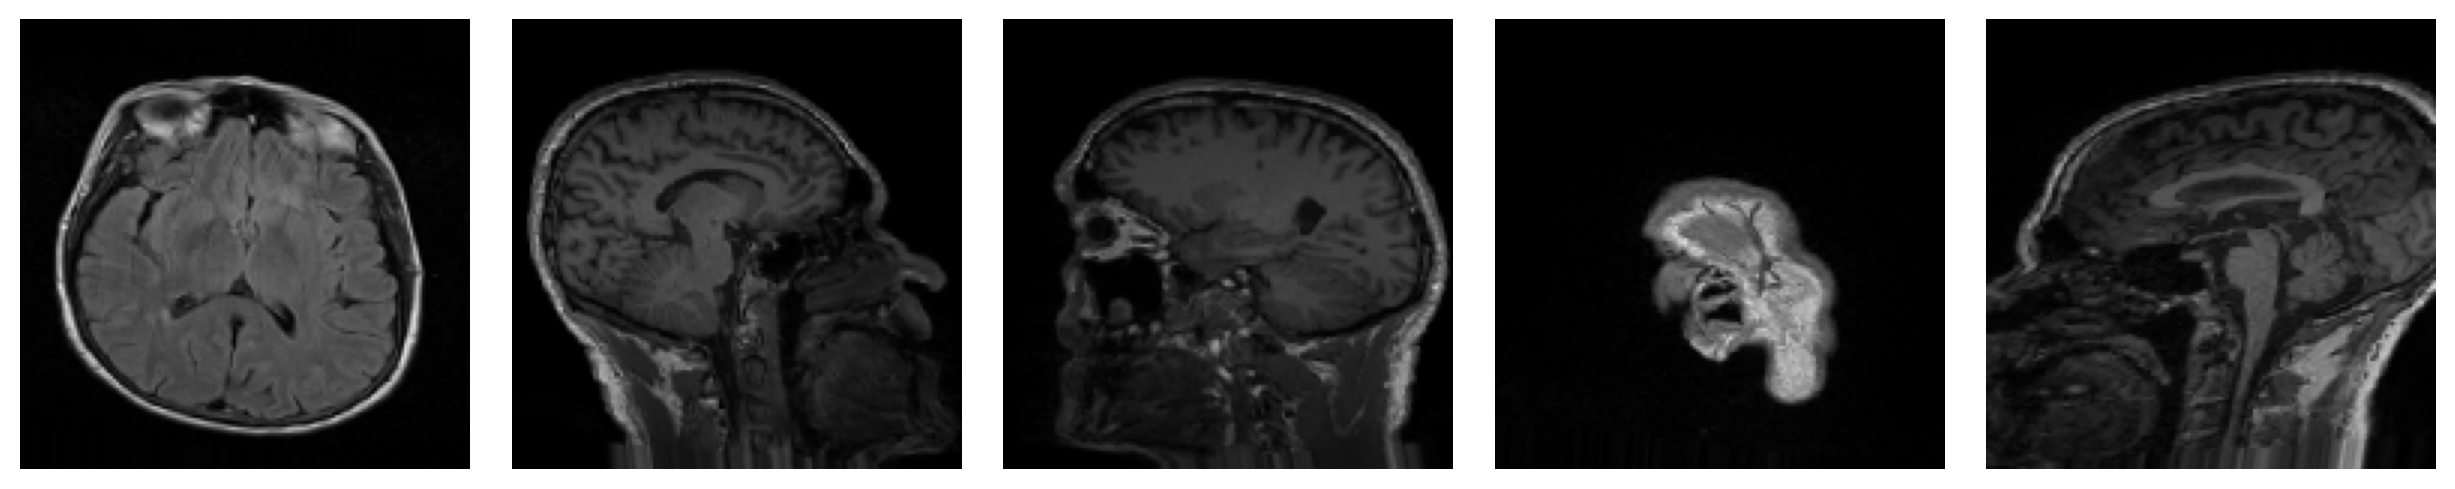

In [608]:
show_ImageDataGenerator(train_datagen_d, num_samples=5, figsize=(12.5, 8), save=SAVE)

#### Training Setup values

In [609]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs_d = 30

# Steps per epoch
steps_per_epoch_d = train_generator_d.samples // batch_size_d

# Validation steps
validation_steps_d = test_generator_d.samples // batch_size_d

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs_d}')
print(f'Batch size: {batch_size_d}')
print(f'Steps Per Epoch: {steps_per_epoch_d}')
print(f'Validation steps: {validation_steps_d}')

Image shape: (150, 150, 3)
Epochs: 30
Batch size: 40
Steps Per Epoch: 194
Validation steps: 63


In [622]:
# Define the model architecture
model_d = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation="relu", input_shape=image_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(N_TYPES, activation="softmax", kernel_regularizer=regularizers.l2(0.01))
    
])

model_d.summary()

optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model_d.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_228 (Conv2D)         (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_159 (B  (None, 148, 148, 32)      128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_171 (MaxPool  (None, 49, 49, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_229 (Conv2D)         (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_160 (B  (None, 47, 47, 64)        256       
 atchNormalization)                                              
                                                     

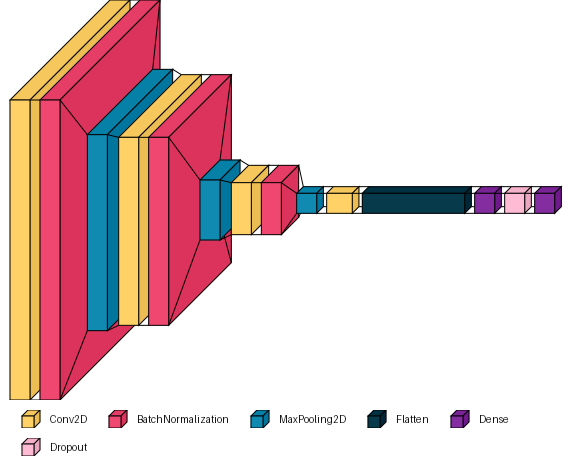

In [623]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)




In [366]:
def scheduler(epoch, lr):
    return lr * 0.9  # Reduce learning rate by 10% every epoch

callback = LearningRateScheduler(scheduler)

In [166]:

checkpoint_d = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint_d_epoch_{epoch:01d}.h5',  # Saves "checkpoint_epoch_01.h5", "checkpoint_epoch_02.h5", etc.
    save_weights_only=True,
    verbose=1
)


In [167]:
# Stop training if loss doesn't keep decreasing.



model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True, restore_best_weights=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history_d = model_d.fit(train_generator1,
                    steps_per_epoch=steps_per_epoch_d,
                    epochs=epochs_d,
                    validation_data=test_generator1,
                    validation_steps=validation_steps_d,
                    callbacks=[model_es, model_rlr,callback, checkpoint_d])


Epoch 1/30
194/194 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.7688
Epoch 1: saving model to checkpoint_d_epoch_1.h5
194/194 [==============================] - 106s 543ms/step - loss: 0.4729 - accuracy: 0.7688 - val_loss: 0.7524 - val_accuracy: 0.7718 - lr: 9.0000e-04
Epoch 2/30
194/194 [==============================] - ETA: 0s - loss: 0.3222 - accuracy: 0.8516
Epoch 2: saving model to checkpoint_d_epoch_2.h5
194/194 [==============================] - 102s 525ms/step - loss: 0.3222 - accuracy: 0.8516 - val_loss: 0.7980 - val_accuracy: 0.7655 - lr: 8.1000e-04
Epoch 3/30
194/194 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.8884
Epoch 3: saving model to checkpoint_d_epoch_3.h5
194/194 [==============================] - 111s 571ms/step - loss: 0.2582 - accuracy: 0.8884 - val_loss: 1.3251 - val_accuracy: 0.5917 - lr: 7.2900e-04
Epoch 4/30
194/194 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9151
Epoch 4: savi

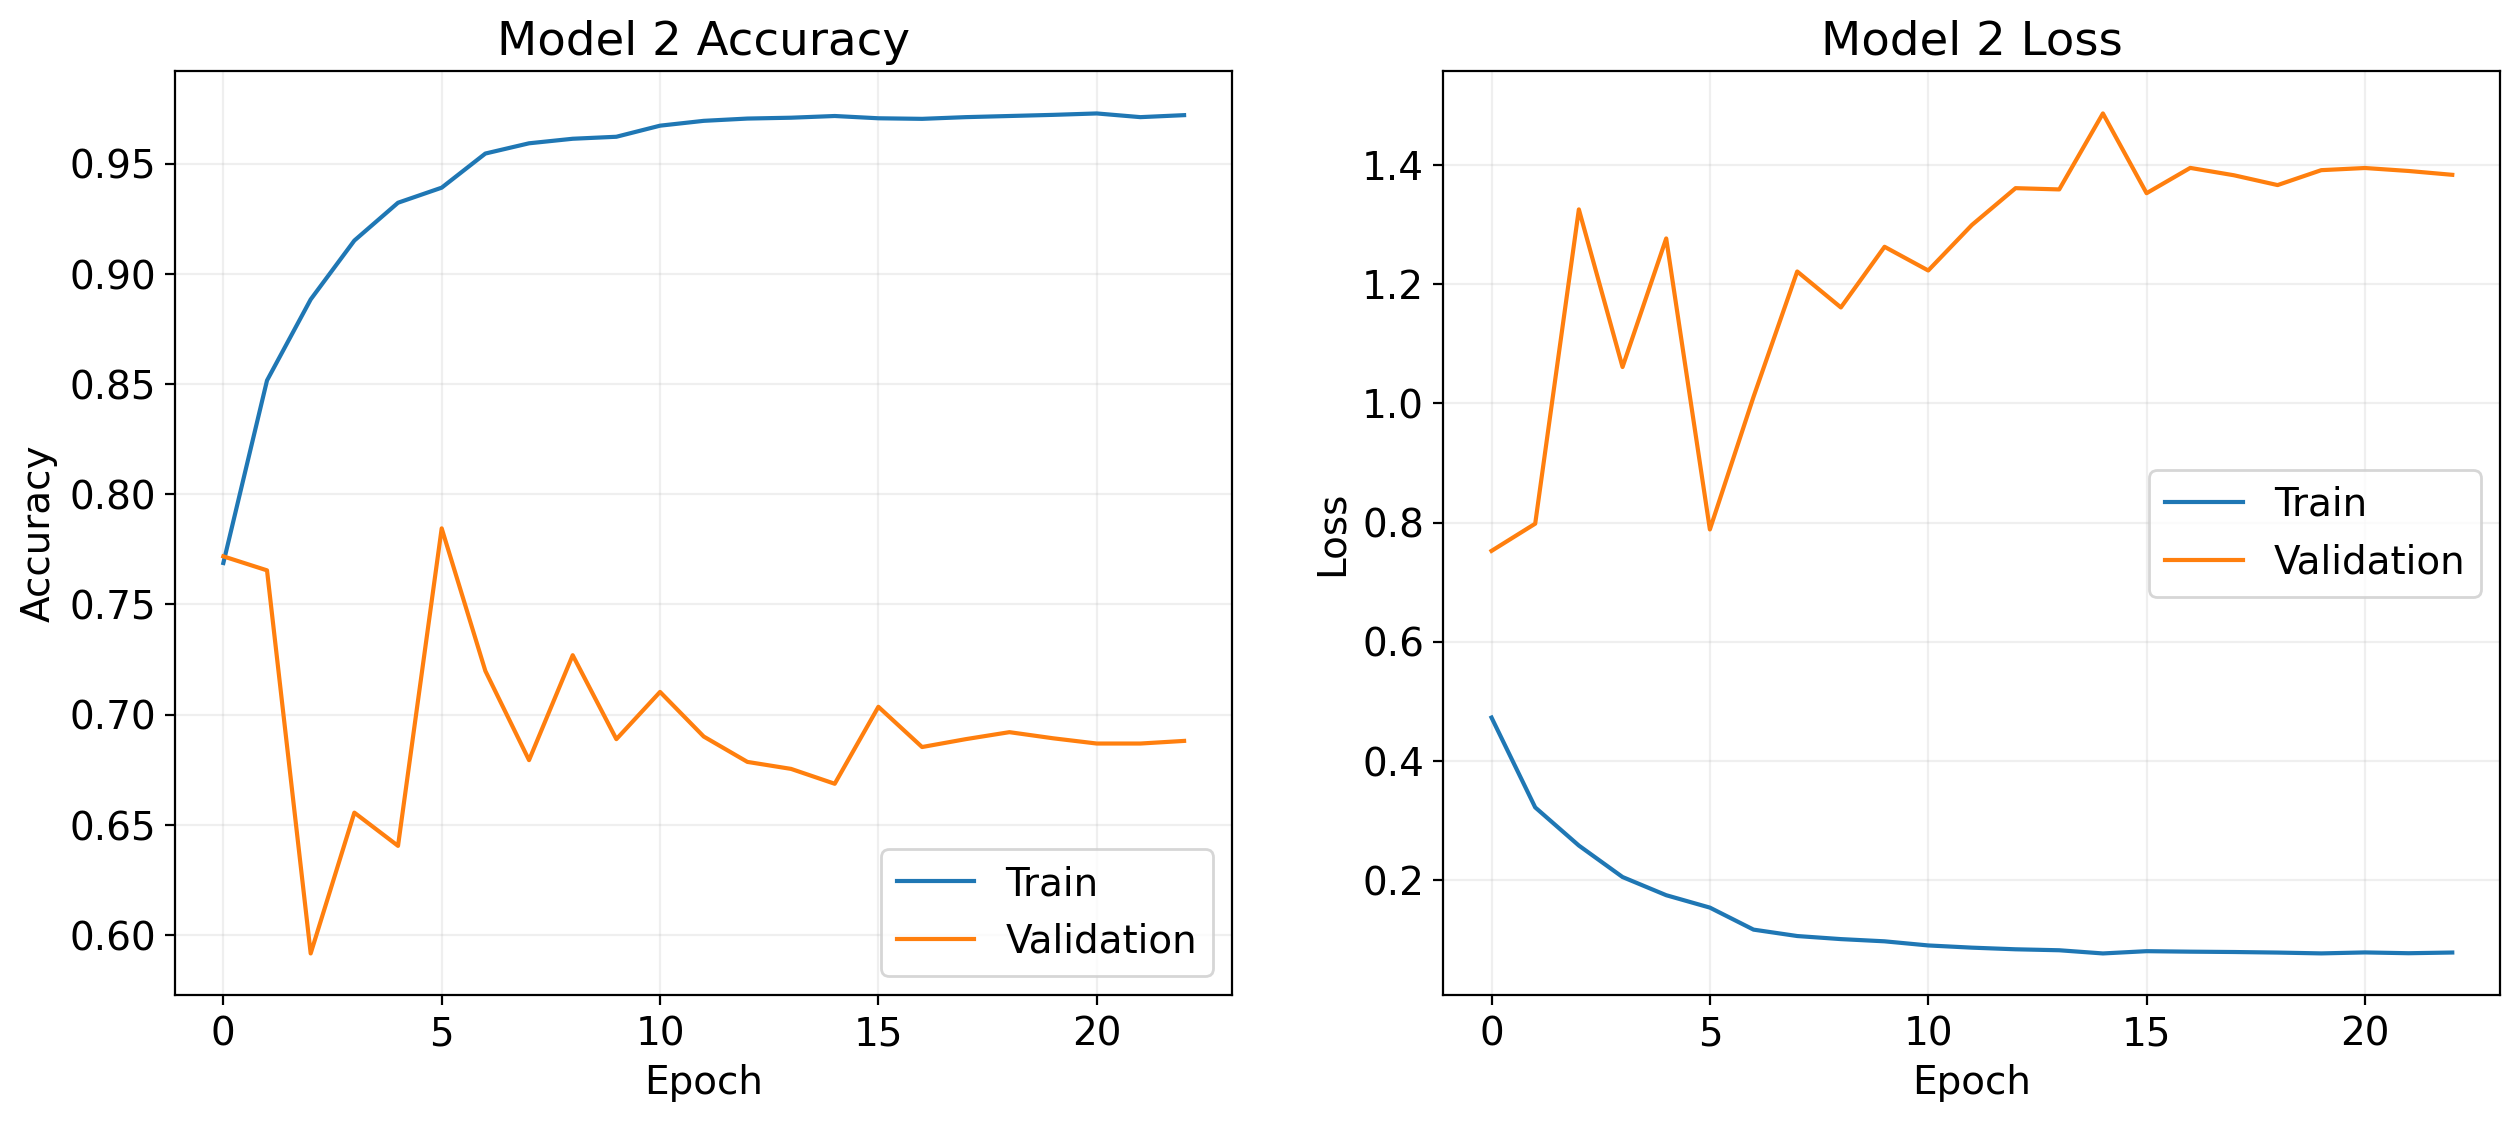

In [168]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history_d.history['accuracy'])
ax[0].plot(history_d.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history_d.history['loss'])
ax[1].plot(history_d.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

In [184]:
epoch_to_restore = 6# Change to the desired epoch
model_d.load_weights(f'checkpoint_d_epoch_{epoch_to_restore:01d}.h5')
print(f"Restored model weights from epoch {epoch_to_restore}")


Restored model weights from epoch 6


In [185]:
loss_d, accuracy_d = model_d.evaluate(test_generator_d, steps=validation_steps_d)
print(f"Validation Loss at Epoch {epoch_to_restore}: {loss_d:.4f}")

print(f"Validation Accuracy at Epoch {epoch_to_restore}: {accuracy_d:.2%}")
print(f"Validation Accuracy at Epoch {epoch_to_restore}: {accuracy_d:0.5}")

63/63 [==============================] - 6s 95ms/step - loss: 0.7883 - accuracy: 0.7845
Validation Loss at Epoch 6: 0.7883
Validation Accuracy at Epoch 6: 78.45%
Validation Accuracy at Epoch 6: 0.78452


64/64 [==============================] - 6s 99ms/step


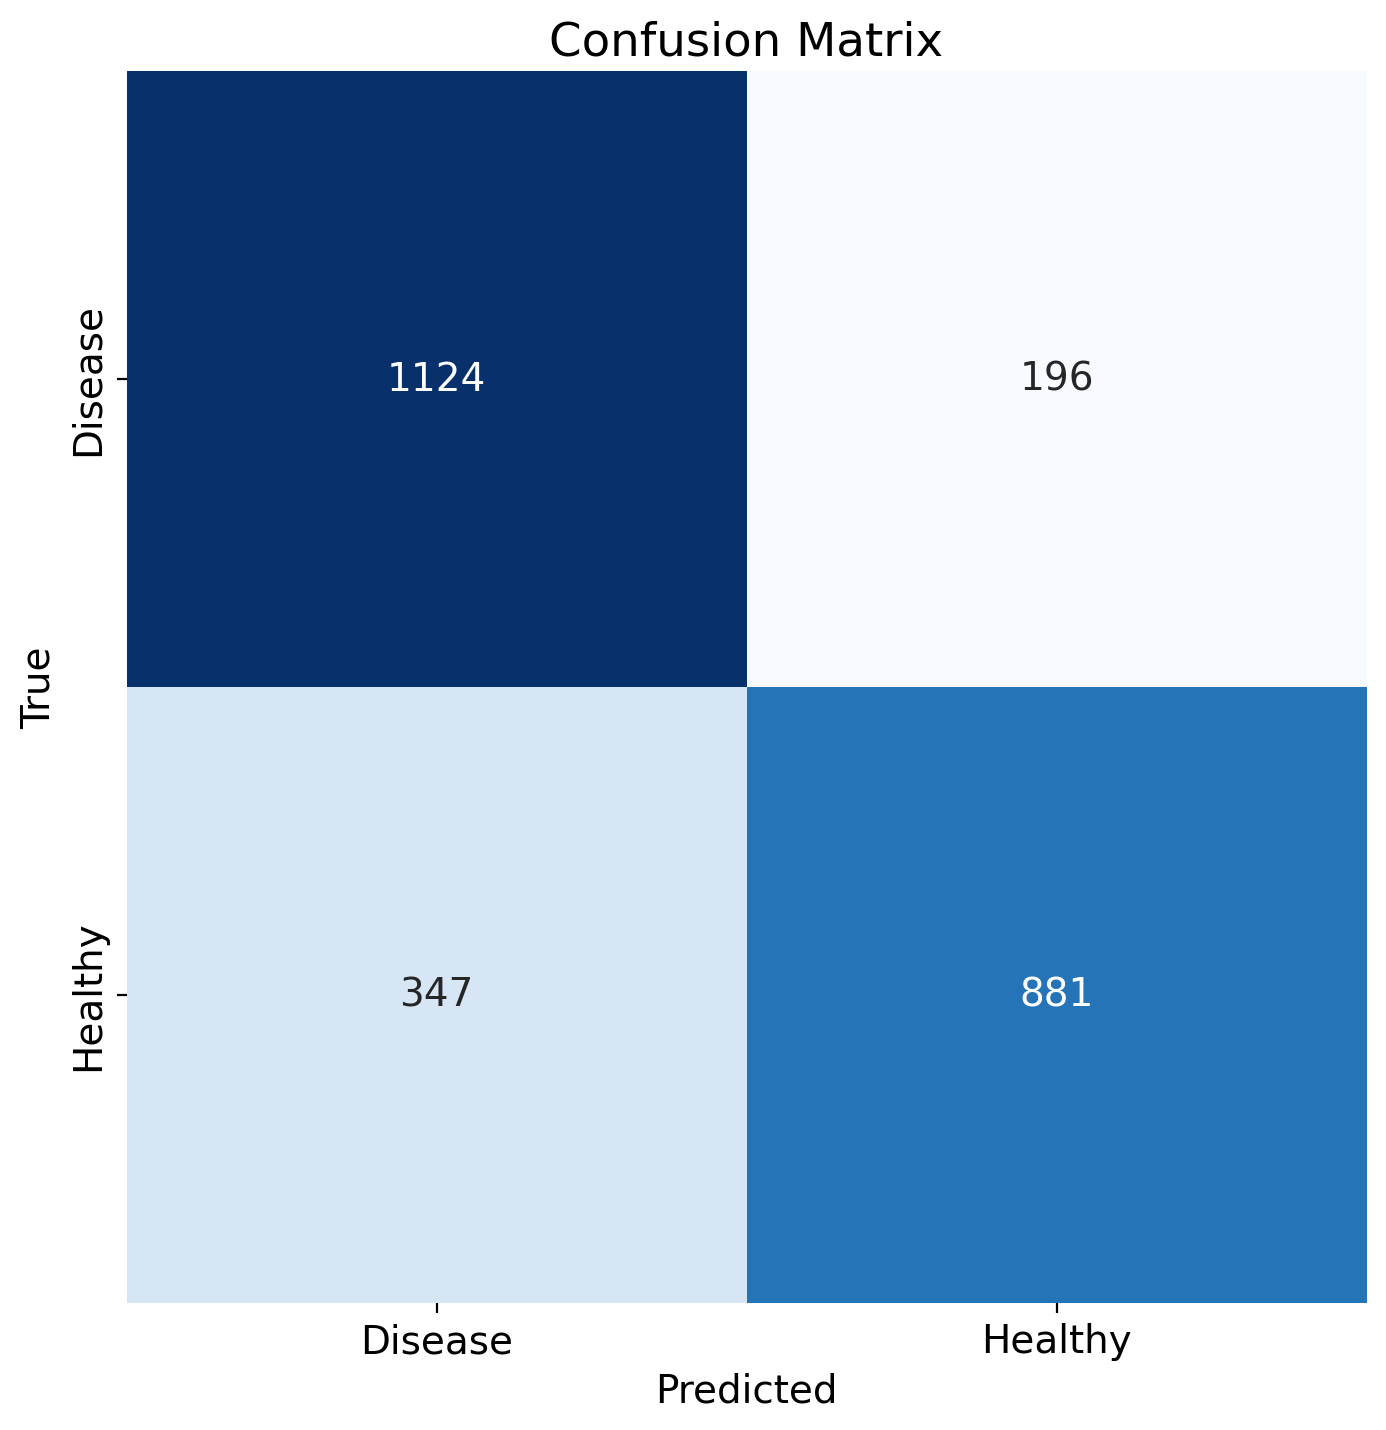

In [186]:
# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model_d, test_generator=test_generator1, categories=class_indices_train_list)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

In [187]:
# Showing metrics
calculate_metrics(confusion_matrix, categories=class_indices_train_list)

Class: Disease
Precision: 0.764
Recall: 0.852
F1-Score: 0.805

Class: Healthy
Precision: 0.818
Recall: 0.717
F1-Score: 0.764


Accuracy: 0.787


## Classification of Disease

In [766]:
# Global variables
SAVE=False
SEED=111


# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES1 = ['Tremor', 'gait disability', 'Healthy']
N_TYPES1 = len(CLASS_TYPES1)

### Importing Data

In [767]:
# Function for inporting data           
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return data_path, data_labels

In [771]:
# Setting up file paths for training and testing
USER_PATH1 = r"C:\Users\anj1ban\OneDrive - Bosch Group\PersonalDrive\Thesis\Topic 2  parkinsons\dataset\PD classification"
train_dir1 = USER_PATH1 + r'/Training Data/'
test_dir1 = USER_PATH1 + r'/Testing Data/'

# Getting data using above function
train_paths1, train_labels1 = get_data_labels(train_dir1)
test_paths1, test_labels1 = get_data_labels(test_dir1)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths1)}')
print(f'Number of Labels: {len(train_labels1)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths1)}')
print(f'Number of Labels: {len(test_labels1)}')


Training
Number of Paths: 13158
Number of Labels: 13158

Testing
Number of Paths: 3583
Number of Labels: 3583


In [772]:
train_dir1 = USER_PATH1 + r'/Training Data/'
train_tremor=train_dir1+CLASS_TYPES1[0]
train_tremor

'C:\\Users\\anj1ban\\OneDrive - Bosch Group\\PersonalDrive\\Thesis\\Topic 2  parkinsons\\dataset\\PD classification/Training Data/Tremor'

Training Counts
{'Tremor': 4401, 'gait disability': 5005, 'Healthy': 3752}

Testing Counts
{'Tremor': 1126, 'gait disability': 1229, 'Healthy': 1228}


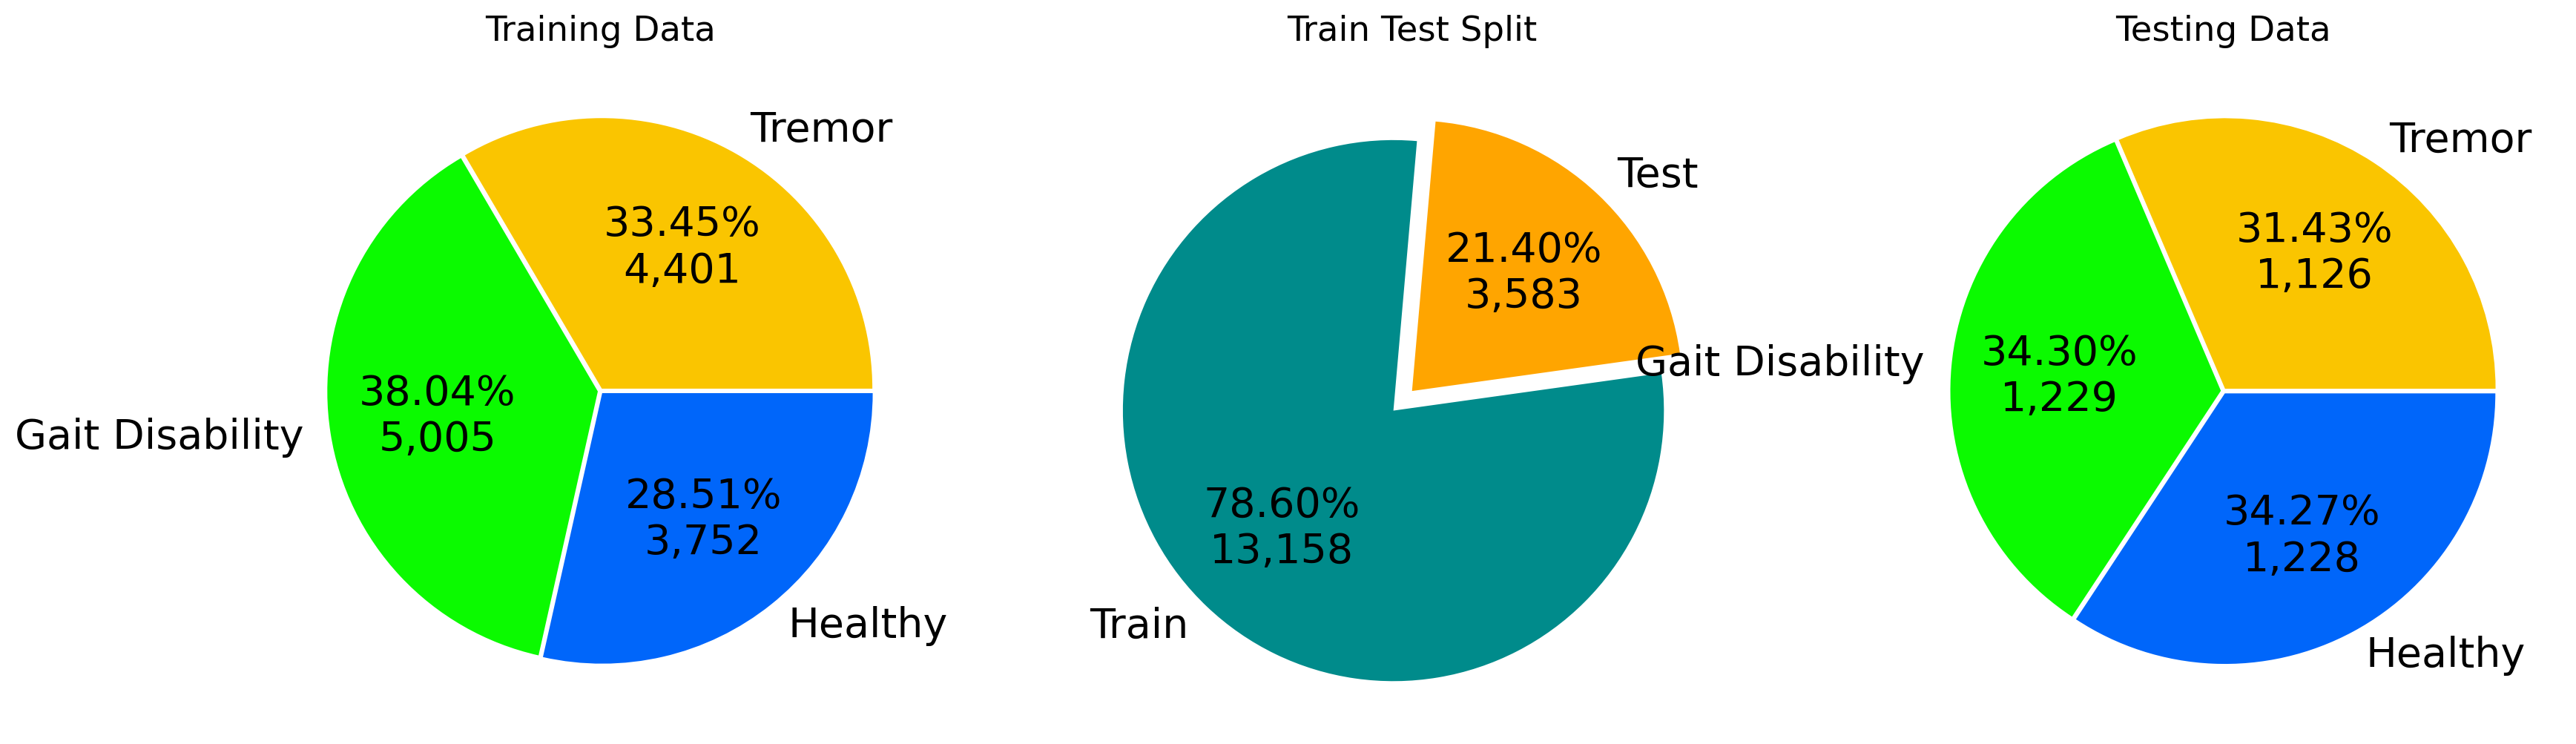

In [773]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts1 = [len([x for x in train_labels1 if x == label]) for label in CLASS_TYPES1]
print('Training Counts')
print(dict(zip(CLASS_TYPES1, class_counts1)))

ax[0].set_title('Training Data')
ax[0].pie(
    class_counts1,
    labels=[label.title() for label in CLASS_TYPES1],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts1) / 100),
    explode=tuple(0.01 for i in range(N_TYPES1)),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_labels1), len(test_labels1)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_labels1), len(test_labels1)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts1 = [len([x for x in test_labels1 if x == label]) for label in CLASS_TYPES1]
print('\nTesting Counts')
print(dict(zip(CLASS_TYPES1, class_counts1)))

ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts1,
    labels=[label.title() for label in CLASS_TYPES1],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts1) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),  # Explode the slices slightly for better visualization
    textprops={'fontsize': 20}  # Set the font size for the text on the pie chart
)


plt.show()

x reshaped: (1, 150, 150, 3)


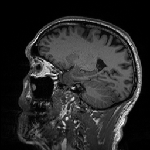

In [774]:
# getting image to test output
im = load_img(train_paths1[301], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')


# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [775]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 8

In [776]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir1,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir1,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 13158 images belonging to 3 classes.
Found 3583 images belonging to 3 classes.


In [777]:
test_generator

### Data Processing and Training setup values

In [778]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'Healthy': 0, 'Tremor': 1, 'gait disability': 2}


In [783]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths1, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        
        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths1[index]}')
        ax[i].axis('off')

    plt.tight_layout()
    
    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()


In [784]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """
    
    # Generate augmented samples
    augmented_samples = train_generator.next()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
        
    plt.tight_layout()
        
    if save:
        plt.savefig('show_ImageDataGenerator.pdf')
        
    plt.show()


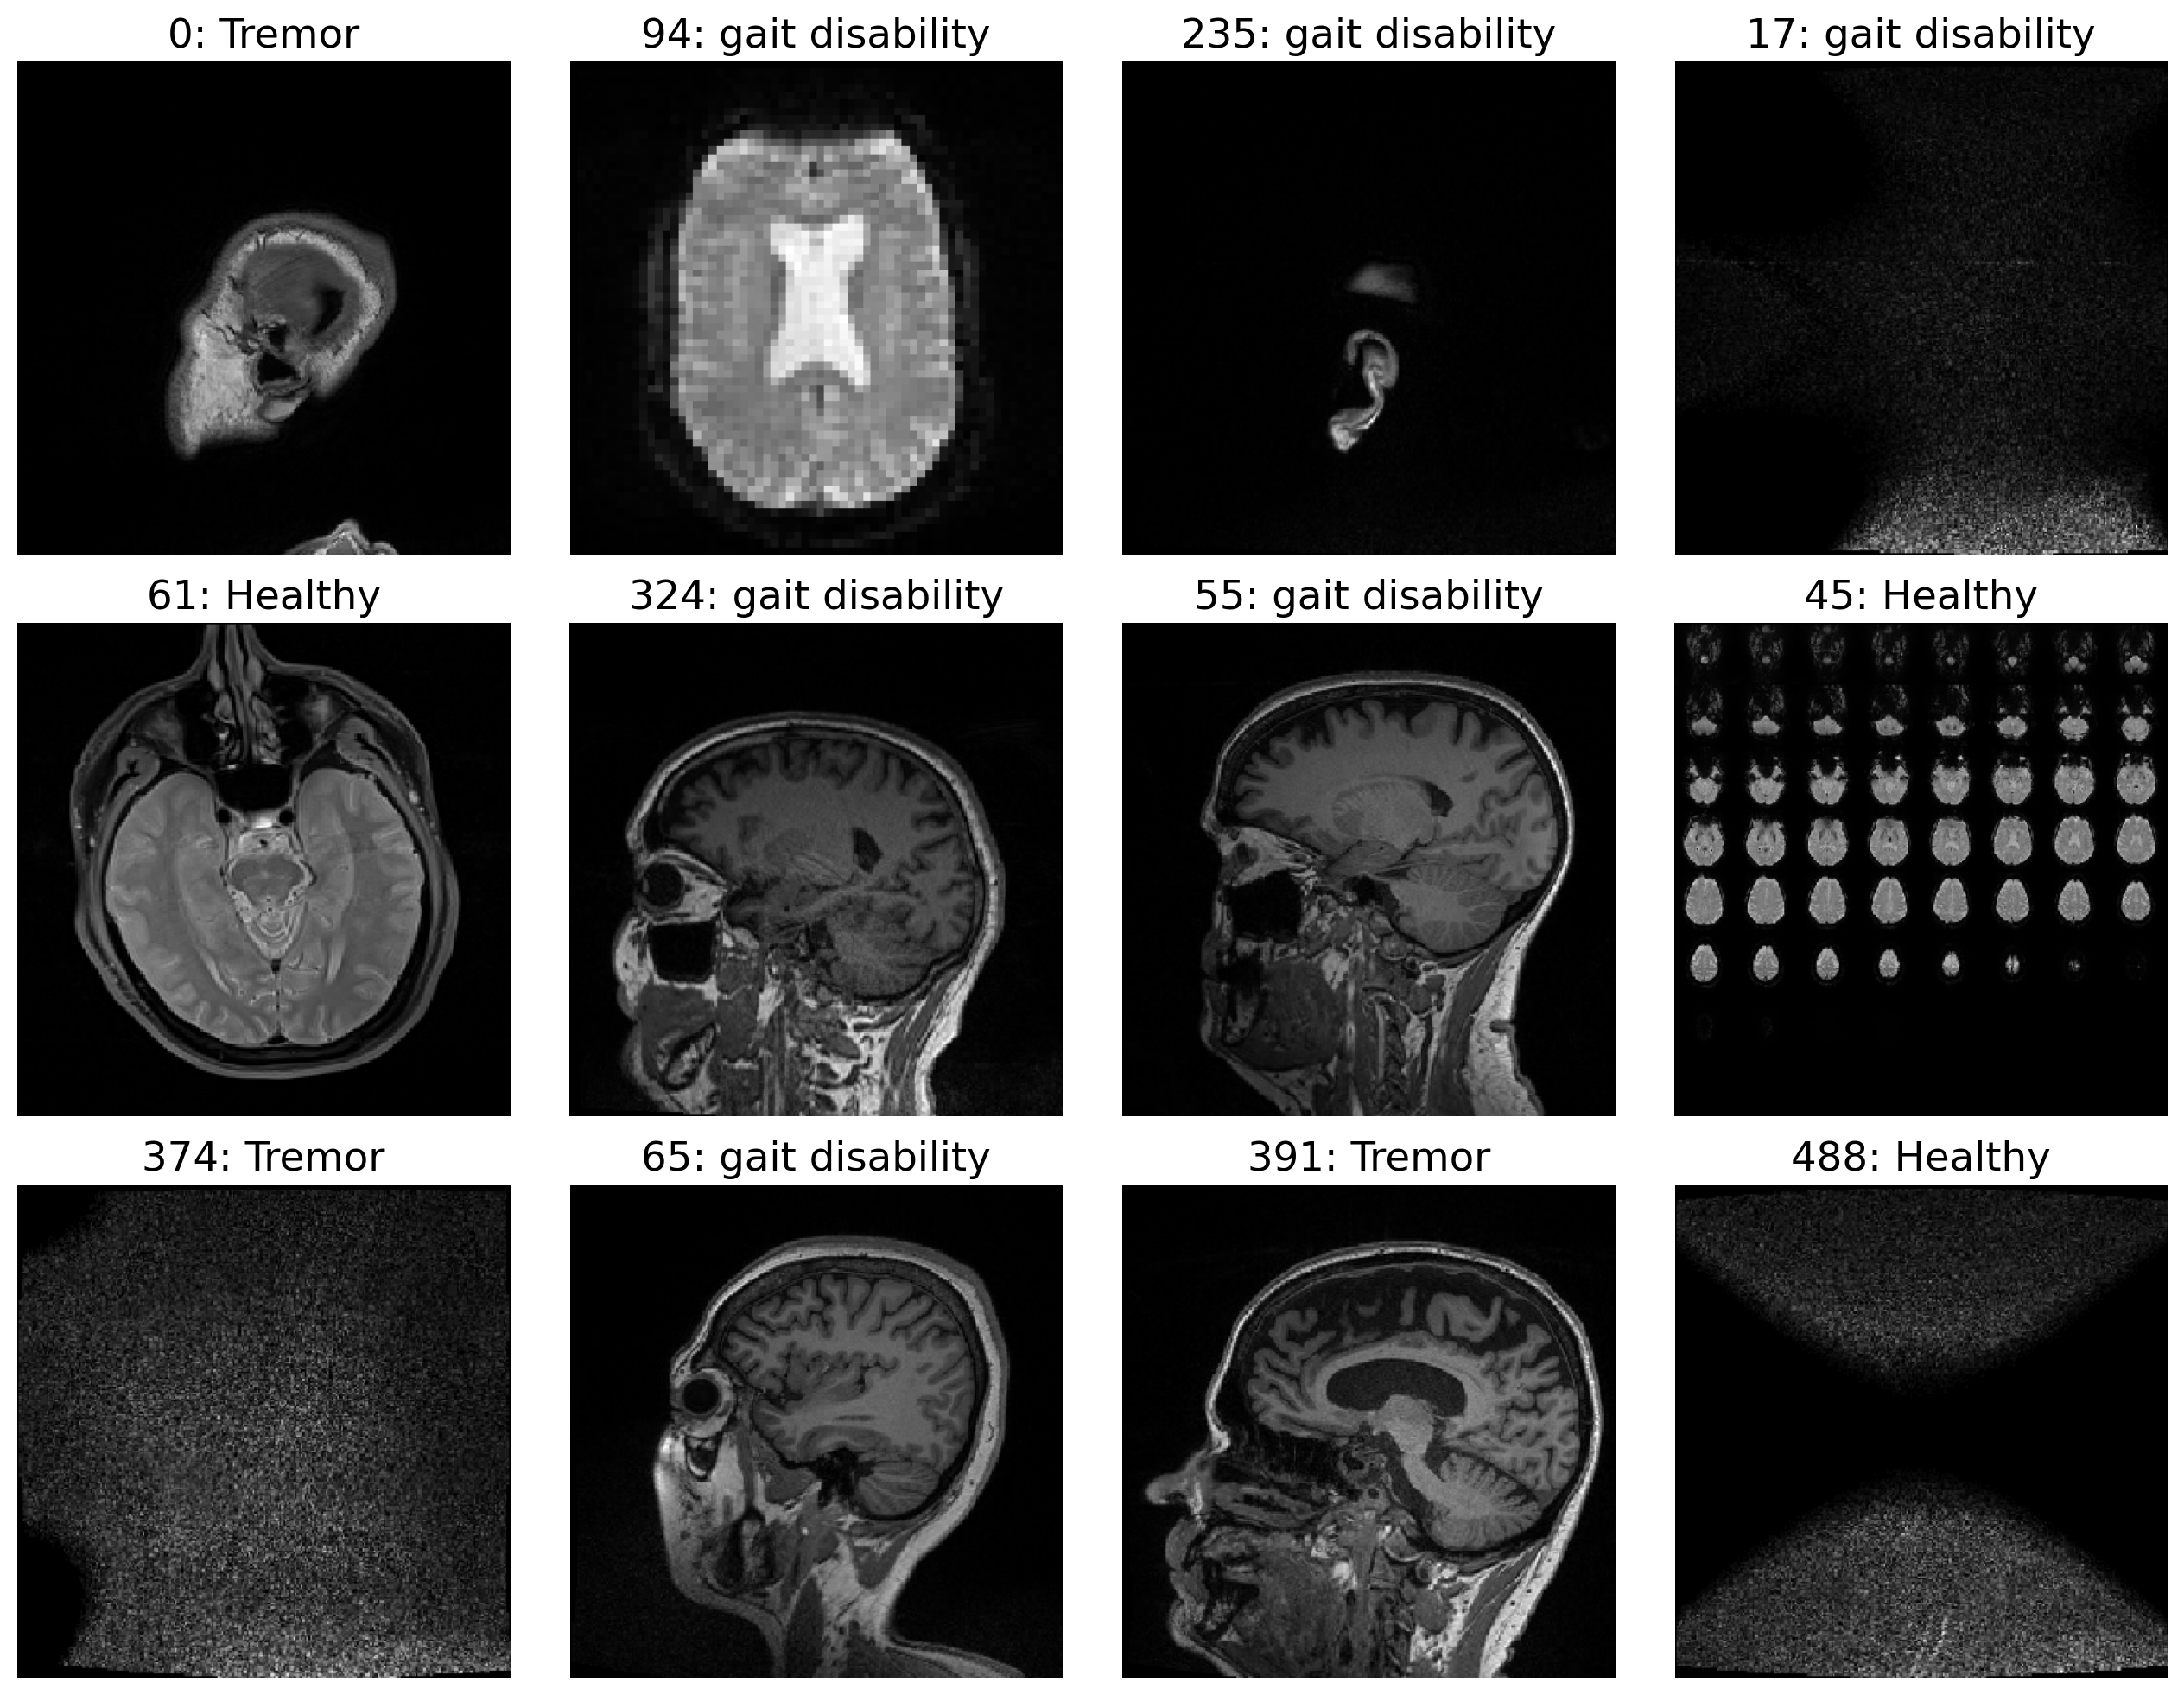

In [785]:
# Four different data classification images, from three different angles (images are independent)
show_images(train_paths1, train_labels1, im_size=350, figsize=(13,10),
            index_list=[0, 94, 235, 17,
                        61, 324, 55, 45,
                        374, 65, 391, 488])

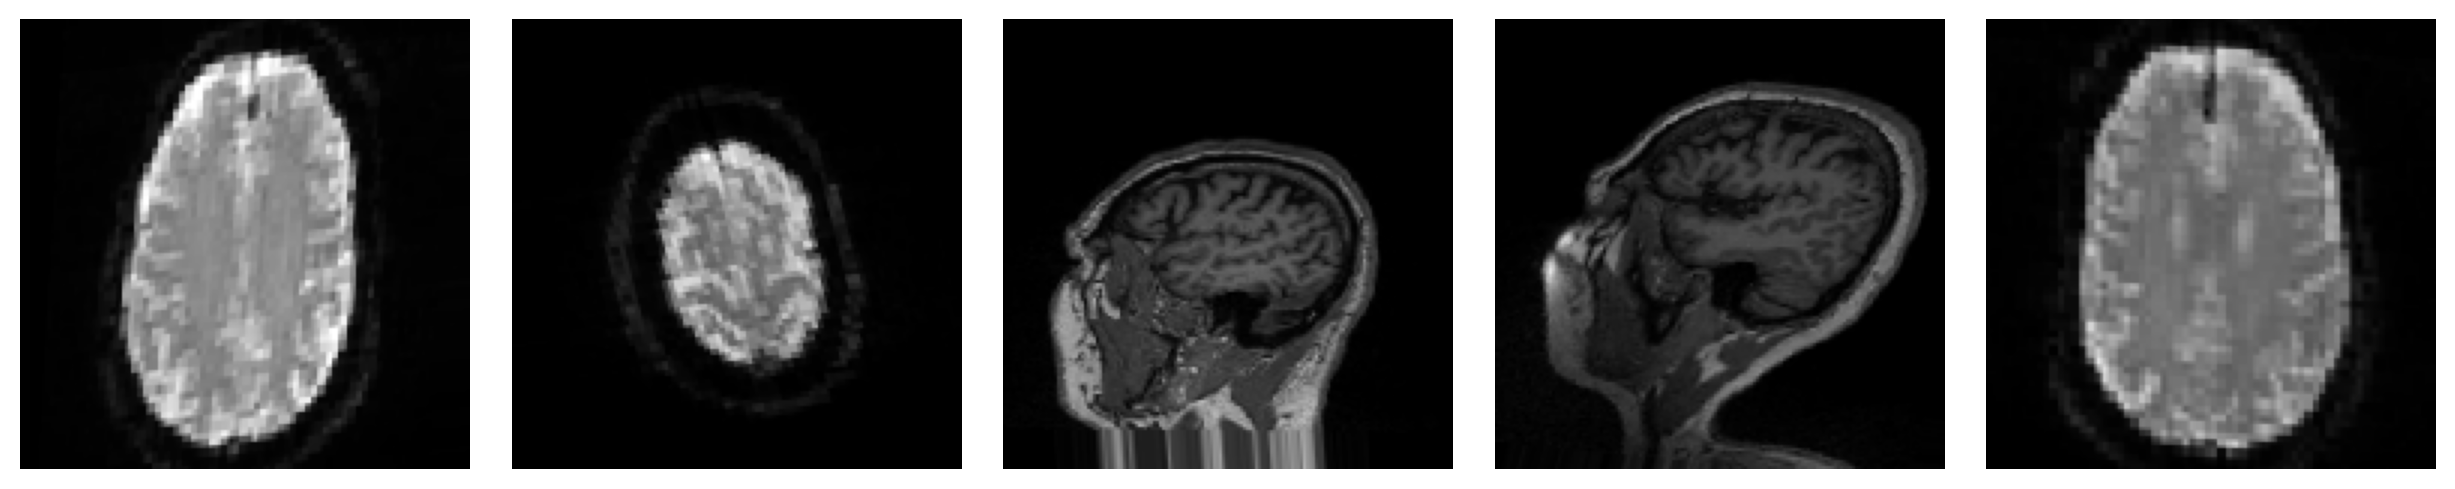

In [786]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=SAVE)

## Training setup values

In [588]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 30

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 30
Batch size: 8
Steps Per Epoch: 1644
Validation steps: 447


In [589]:
# –––––––––––––––––––––––––––––––––––––– #
# Output Images and Labels Visualization #
# –––––––––––––––––––––––––––––––––––––– #
def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(12, 8)):
    """
    Nice display of prediction samples to see CNN predictions
    for classification.
    """
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)
    
    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")
        
        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)
        
    plt.tight_layout()
    plt.show()

    
# –––––––––––––––––––––––––––––––––––––– #
#            Confusion matrix            #
# –––––––––––––––––––––––––––––––––––––– #
def CM(CNN_model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    
    return confusion_matrix_array


# –––––––––––––––––––––––––––––––––––––– #
#             Metric Analysis            #
# –––––––––––––––––––––––––––––––––––––– #
def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")
        
    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")


In [590]:
# Define the model architecture
model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation="relu", input_shape=image_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    
    MaxPooling2D(pool_size=(3, 3)),
    
    # Convolutional layer 4
    Conv2D(256, (3, 3), activation="relu"),
    Flatten(),


    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(N_TYPES, activation="softmax", kernel_regularizer=regularizers.l2(0.01))
    
])

model.summary()

optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_204 (Conv2D)         (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_153 (B  (None, 148, 148, 32)      128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_153 (MaxPool  (None, 49, 49, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_205 (Conv2D)         (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_154 (B  (None, 47, 47, 64)        256       
 atchNormalization)                                              
                                                     

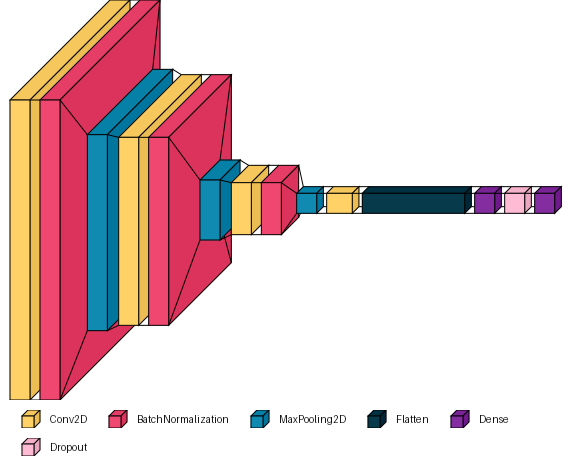

In [574]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)




In [576]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [577]:
def scheduler(epoch, lr):
    return lr * 0.9  # Reduce learning rate by 10% every epoch

callback = LearningRateScheduler(scheduler)

In [578]:

checkpoint_c = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint_c_epoch_{epoch:01d}.h5',  # Saves "checkpoint_epoch_01.h5", "checkpoint_epoch_02.h5", etc.
    save_weights_only=True,
    verbose=1
)


In [579]:

checkpoint_c1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint_c1_epoch_{epoch:01d}.h5',  # Saves "checkpoint_epoch_01.h5", "checkpoint_epoch_02.h5", etc.
    save_weights_only=True,
    verbose=1
)


In [572]:
# Stop training if loss doesn't keep decreasing.



model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True, restore_best_weights=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr, callback, checkpoint_c])


Epoch 1/30
1644/1644 [==============================] - ETA: 0s - loss: 0.9919 - accuracy: 0.4736
Epoch 1: saving model to checkpoint_c_epoch_1.h5
1644/1644 [==============================] - 169s 102ms/step - loss: 0.9919 - accuracy: 0.4736 - val_loss: 1.0808 - val_accuracy: 0.3993 - lr: 9.0000e-04
Epoch 2/30
1644/1644 [==============================] - ETA: 0s - loss: 0.8528 - accuracy: 0.5614
Epoch 2: saving model to checkpoint_c_epoch_2.h5
1644/1644 [==============================] - 205s 125ms/step - loss: 0.8528 - accuracy: 0.5614 - val_loss: 0.9341 - val_accuracy: 0.4843 - lr: 8.1000e-04
Epoch 3/30
1644/1644 [==============================] - ETA: 0s - loss: 0.7173 - accuracy: 0.6401
Epoch 3: saving model to checkpoint_c_epoch_3.h5
1644/1644 [==============================] - 205s 124ms/step - loss: 0.7173 - accuracy: 0.6401 - val_loss: 0.9871 - val_accuracy: 0.4824 - lr: 7.2900e-04
Epoch 4/30
1644/1644 [==============================] - ETA: 0s - loss: 0.6301 - accuracy: 0.6958

# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=39)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5}")

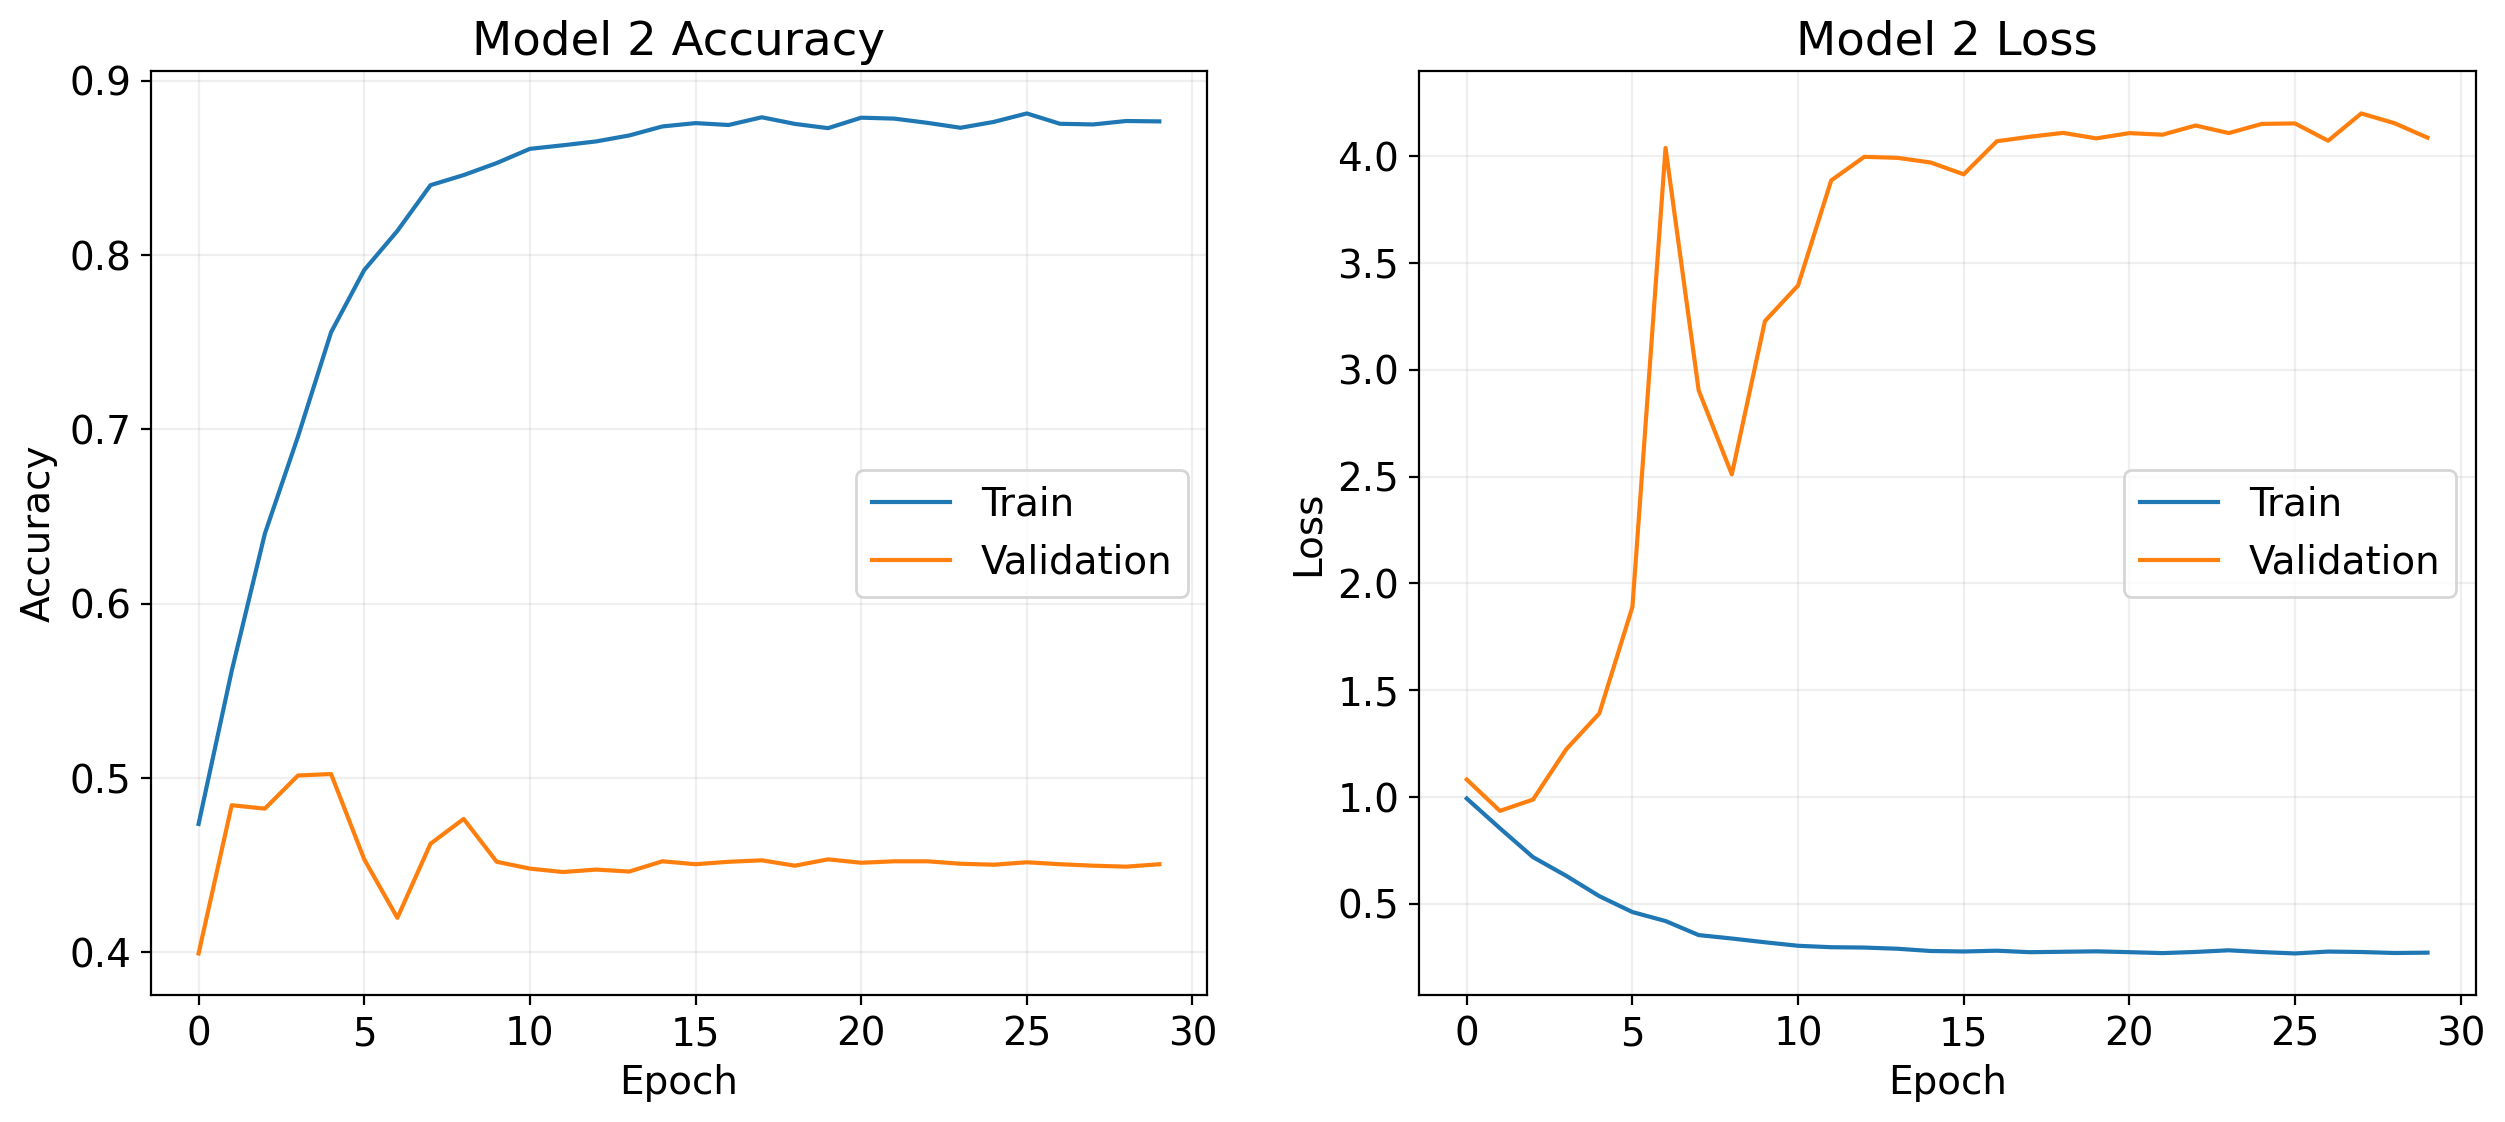

In [580]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

In [584]:
epoch_to_restore = 4 # Change to the desired epoch
model.load_weights(f'checkpoint_c_epoch_{epoch_to_restore:01d}.h5')
print(f"Restored model weights from epoch {epoch_to_restore}")    


Restored model weights from epoch 4


In [585]:
loss, accuracy = model.evaluate(test_generator, steps=validation_steps)
print(f"Validation Loss at Epoch {epoch_to_restore}: {loss:.4f}")

print(f"Validation Accuracy at Epoch {epoch_to_restore}: {accuracy:.2%}")
print(f"Validation Accuracy at Epoch {epoch_to_restore}: {accuracy:0.5}")

447/447 [==============================] - 15s 34ms/step - loss: 1.2221 - accuracy: 0.5014
Validation Loss at Epoch 4: 1.2221
Validation Accuracy at Epoch 4: 50.14%
Validation Accuracy at Epoch 4: 0.5014


448/448 [==============================] - 15s 34ms/step


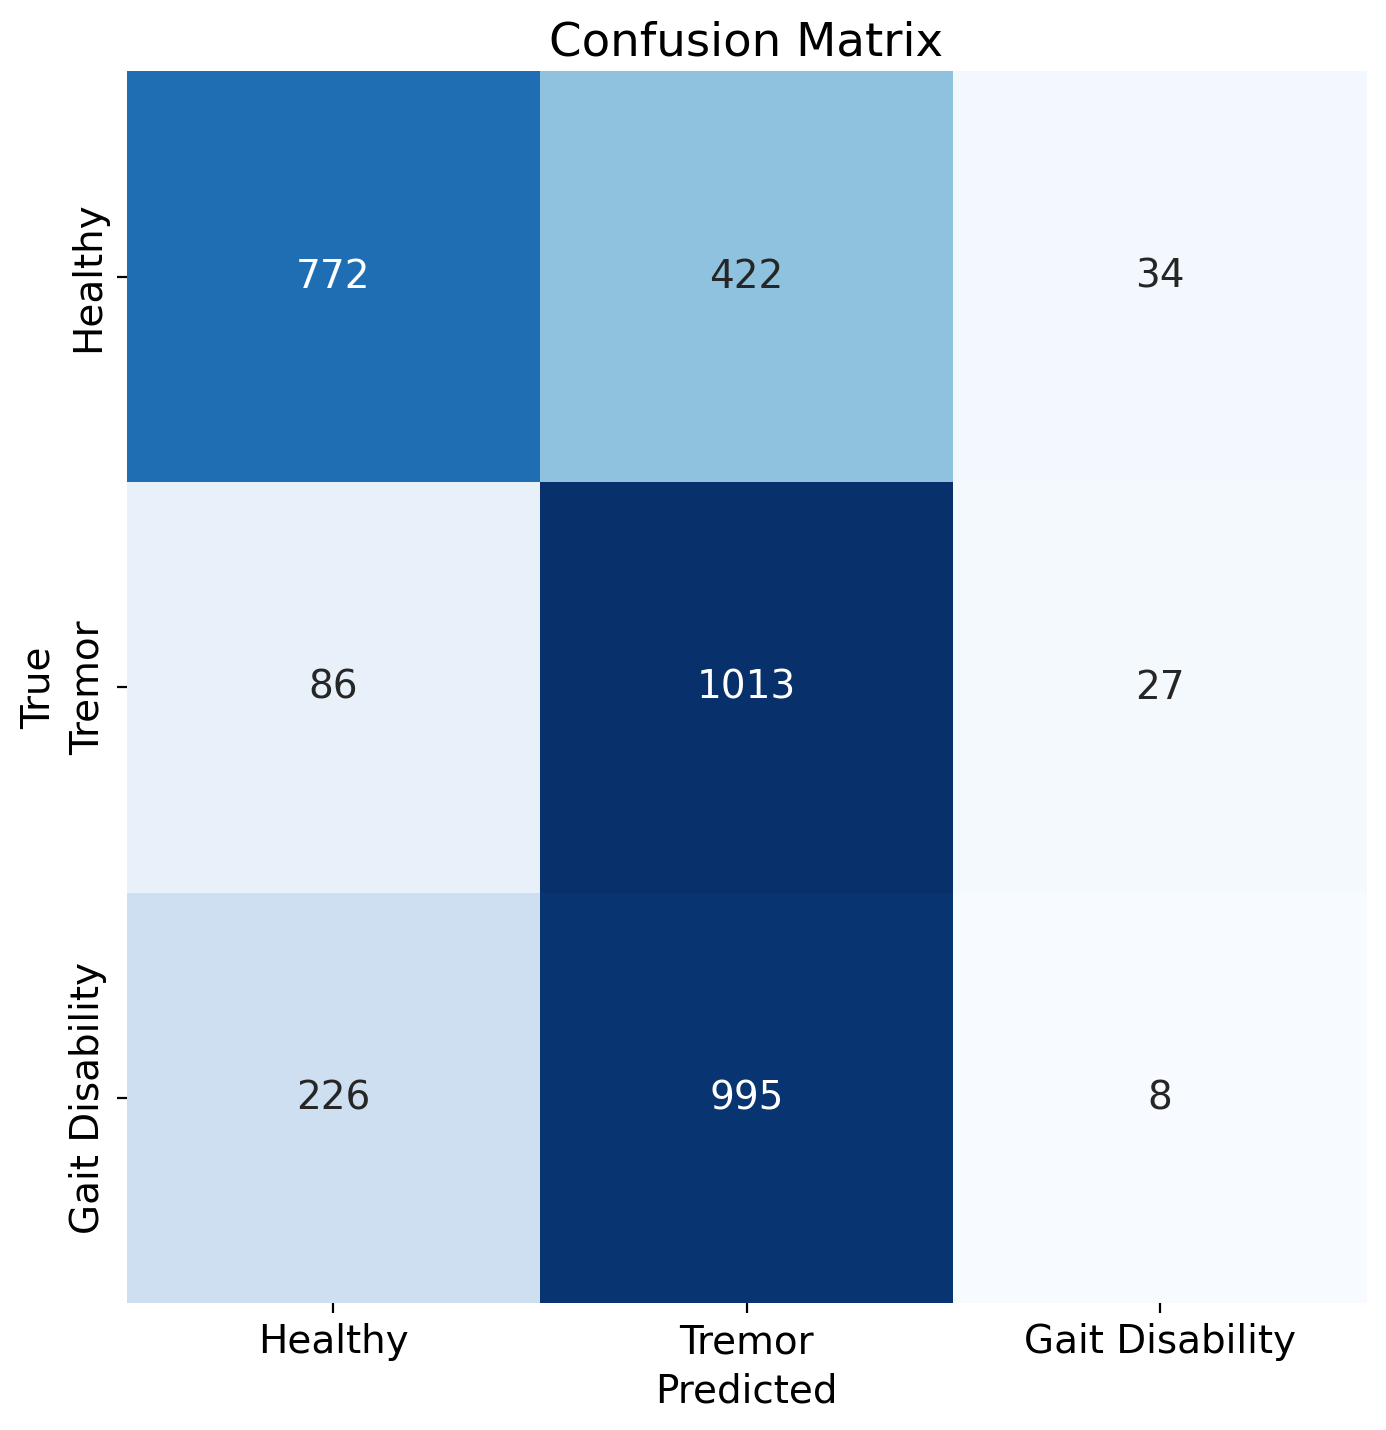

In [586]:
# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

In [587]:
# Showing metrics
calculate_metrics(confusion_matrix, categories=class_indices_train_list)

Class: Healthy
Precision: 0.712
Recall: 0.629
F1-Score: 0.668

Class: Tremor
Precision: 0.417
Recall: 0.900
F1-Score: 0.570

Class: Gait Disability
Precision: 0.116
Recall: 0.007
F1-Score: 0.012


Accuracy: 0.500


## Dense Net

x reshaped: (224, 224, 3)


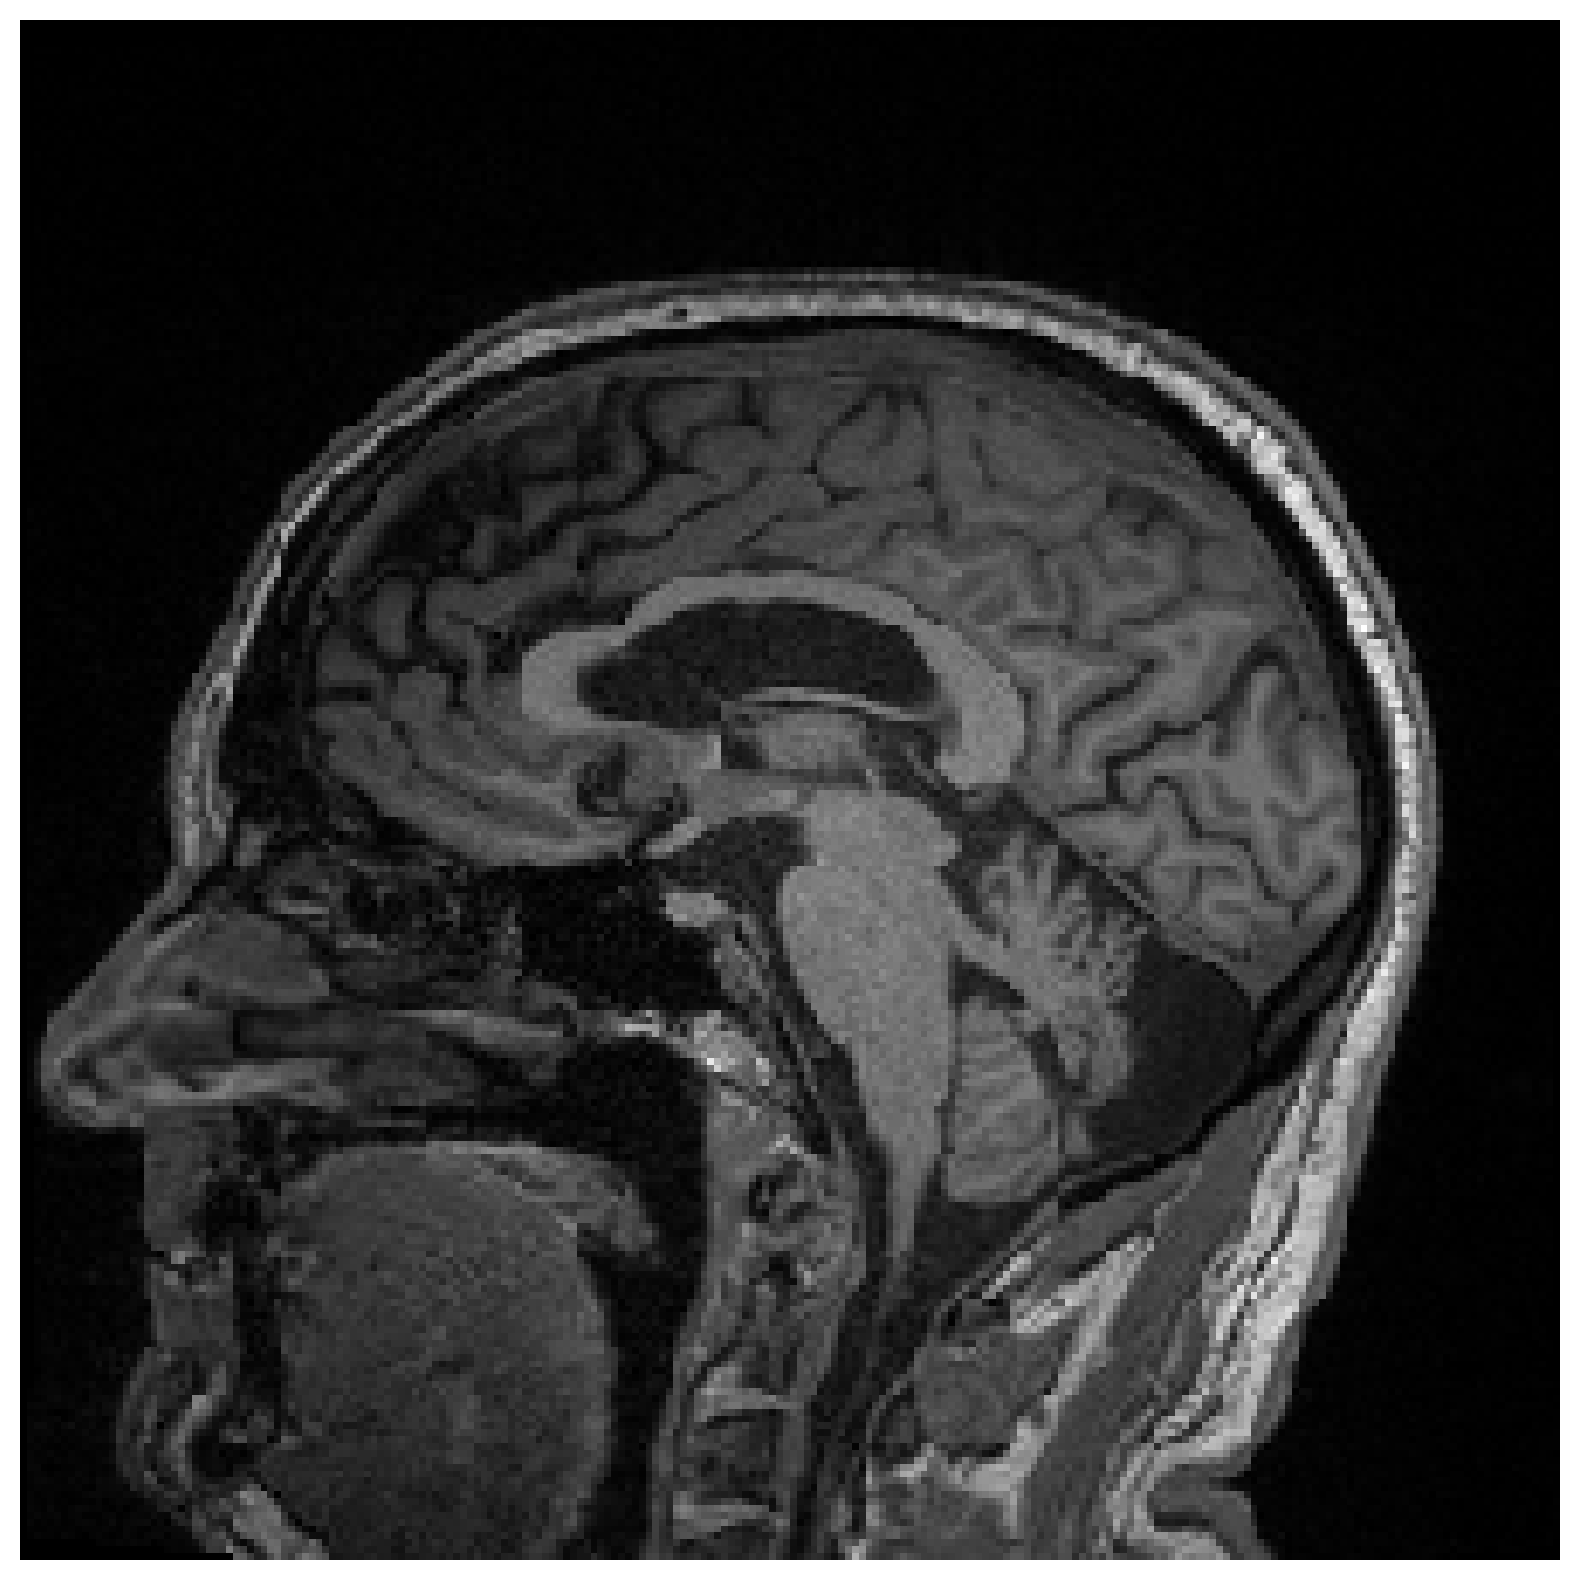

In [788]:
# getting image to test output
img = load_img(train_paths1[1000], target_size=(224, 224))
img = img_to_array(img)

# Reshape it to (1, 150, 150, 3)
img = np.expand_dims(img, axis=0)
img = np.squeeze(img, axis=0)

print(f'x reshaped: {img.shape}')

# Convert grayscale MRI scans to 3-channel format
#img = np.stack((img,) * 3, axis=-1)


# normilzation tensor
img /= np.max(img) # ~ np.max(img_tensor)

# Convert the array back to the image format
plt.imshow(img)
plt.axis("off")
plt.show()



In [849]:
# Image size
image_size = (224, 224)

# Training batch size
batch_size1 = 80

In [850]:
# Data augmentation and preprocessing
train_datagen1 = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator1 = train_datagen1.flow_from_directory(train_dir1,
                                                    target_size=image_size,
                                                    batch_size=batch_size1,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen1 = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator1 = test_datagen1.flow_from_directory(test_dir1,
                                                  target_size=image_size,
                                                  batch_size=batch_size1,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 13158 images belonging to 3 classes.
Found 3583 images belonging to 3 classes.


In [851]:
# Accessing class indices for training data generator
class_indices_train1 = train_generator1.class_indices
class_indices_train_list1 = list(train_generator1.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train1)

Categorical types for the training data:
{'Healthy': 0, 'Tremor': 1, 'gait disability': 2}


In [852]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths1, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        
        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths1[index]}')
        ax[i].axis('off')

    plt.tight_layout()
    
    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()


In [853]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """
    
    # Generate augmented samples
    augmented_samples = train_generator1.next()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
        
    plt.tight_layout()
        
    if save:
        plt.savefig('show_ImageDataGenerator.pdf')
        
    plt.show()


In [856]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs1 = 10

# Steps per epoch
steps_per_epoch1 = train_generator1.samples // batch_size1

# Validation steps
validation_steps1 =25

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs1}')
print(f'Batch size: {batch_size1}')
print(f'Steps Per Epoch: {steps_per_epoch1}')
print(f'Validation steps: {validation_steps1}')

Image shape: (224, 224, 3)
Epochs: 10
Batch size: 80
Steps Per Epoch: 164
Validation steps: 25


In [857]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

In [858]:

base_model1 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model1.trainable = False
x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)
  # Add dropout for regularization
x1 = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(256, activation='sigmoid')(x1)
x1= Dropout(0.5)(x1)
predictions = Dense(train_generator.num_classes, activation='softmax')(x1)





model1 = Model(inputs=base_model1.input, outputs=predictions)

    # Freeze the base layers for transfer learning
base_model1.trainable = True
for layer in base_model1.layers[:300]:
    layer.trainable = False

    # Compile the model
model1.compile(optimizer=Adam(learning_rate=0.00005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    

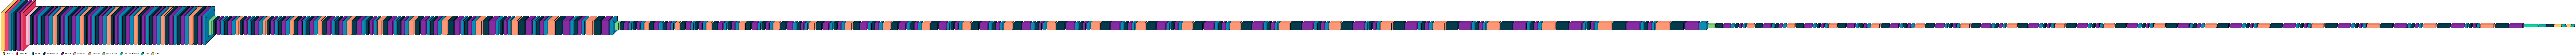

In [859]:
from visualkeras import layered_view

# Visualize the model
layered_view(model2, legend=True, max_xy=300)

In [860]:

checkpoint1_ck = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint_epoch_{epoch:02d}.h5',  # Saves "checkpoint_epoch_01.h5", "checkpoint_epoch_02.h5", etc.
    save_weights_only=True,
    verbose=1
)


In [861]:
def scheduler(epoch, lr):
    return lr * 0.9  # Reduce learning rate by 10% every epoch

callback1 = LearningRateScheduler(scheduler)

In [862]:
# Stop training if loss doesn't keep decreasing.

model_es2 = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history1 = model1.fit(train_generator1,
                    steps_per_epoch=steps_per_epoch1,
                    epochs=epochs1,
                    validation_data=test_generator1,
                    validation_steps=validation_steps1,
                    callbacks=[model_es2, model_rlr2,callback1,checkpoint1_ck])

Epoch 1/10
164/164 [==============================] - ETA: 0s - loss: 6.9182 - accuracy: 0.6651 
Epoch 1: saving model to checkpoint_epoch_01.h5
164/164 [==============================] - 2224s 13s/step - loss: 6.9182 - accuracy: 0.6651 - val_loss: 6.2049 - val_accuracy: 0.6735 - lr: 4.5000e-05
Epoch 2/10
164/164 [==============================] - ETA: 0s - loss: 5.5052 - accuracy: 0.8073 
Epoch 2: saving model to checkpoint_epoch_02.h5
164/164 [==============================] - 2164s 13s/step - loss: 5.5052 - accuracy: 0.8073 - val_loss: 5.1701 - val_accuracy: 0.7040 - lr: 4.0500e-05
Epoch 3/10
164/164 [==============================] - ETA: 0s - loss: 4.5519 - accuracy: 0.8696 
Epoch 3: saving model to checkpoint_epoch_03.h5
164/164 [==============================] - 2213s 13s/step - loss: 4.5519 - accuracy: 0.8696 - val_loss: 4.7125 - val_accuracy: 0.6440 - lr: 3.6450e-05
Epoch 4/10
164/164 [==============================] - ETA: 0s - loss: 3.8544 - accuracy: 0.9091 
Epoch 4: saving

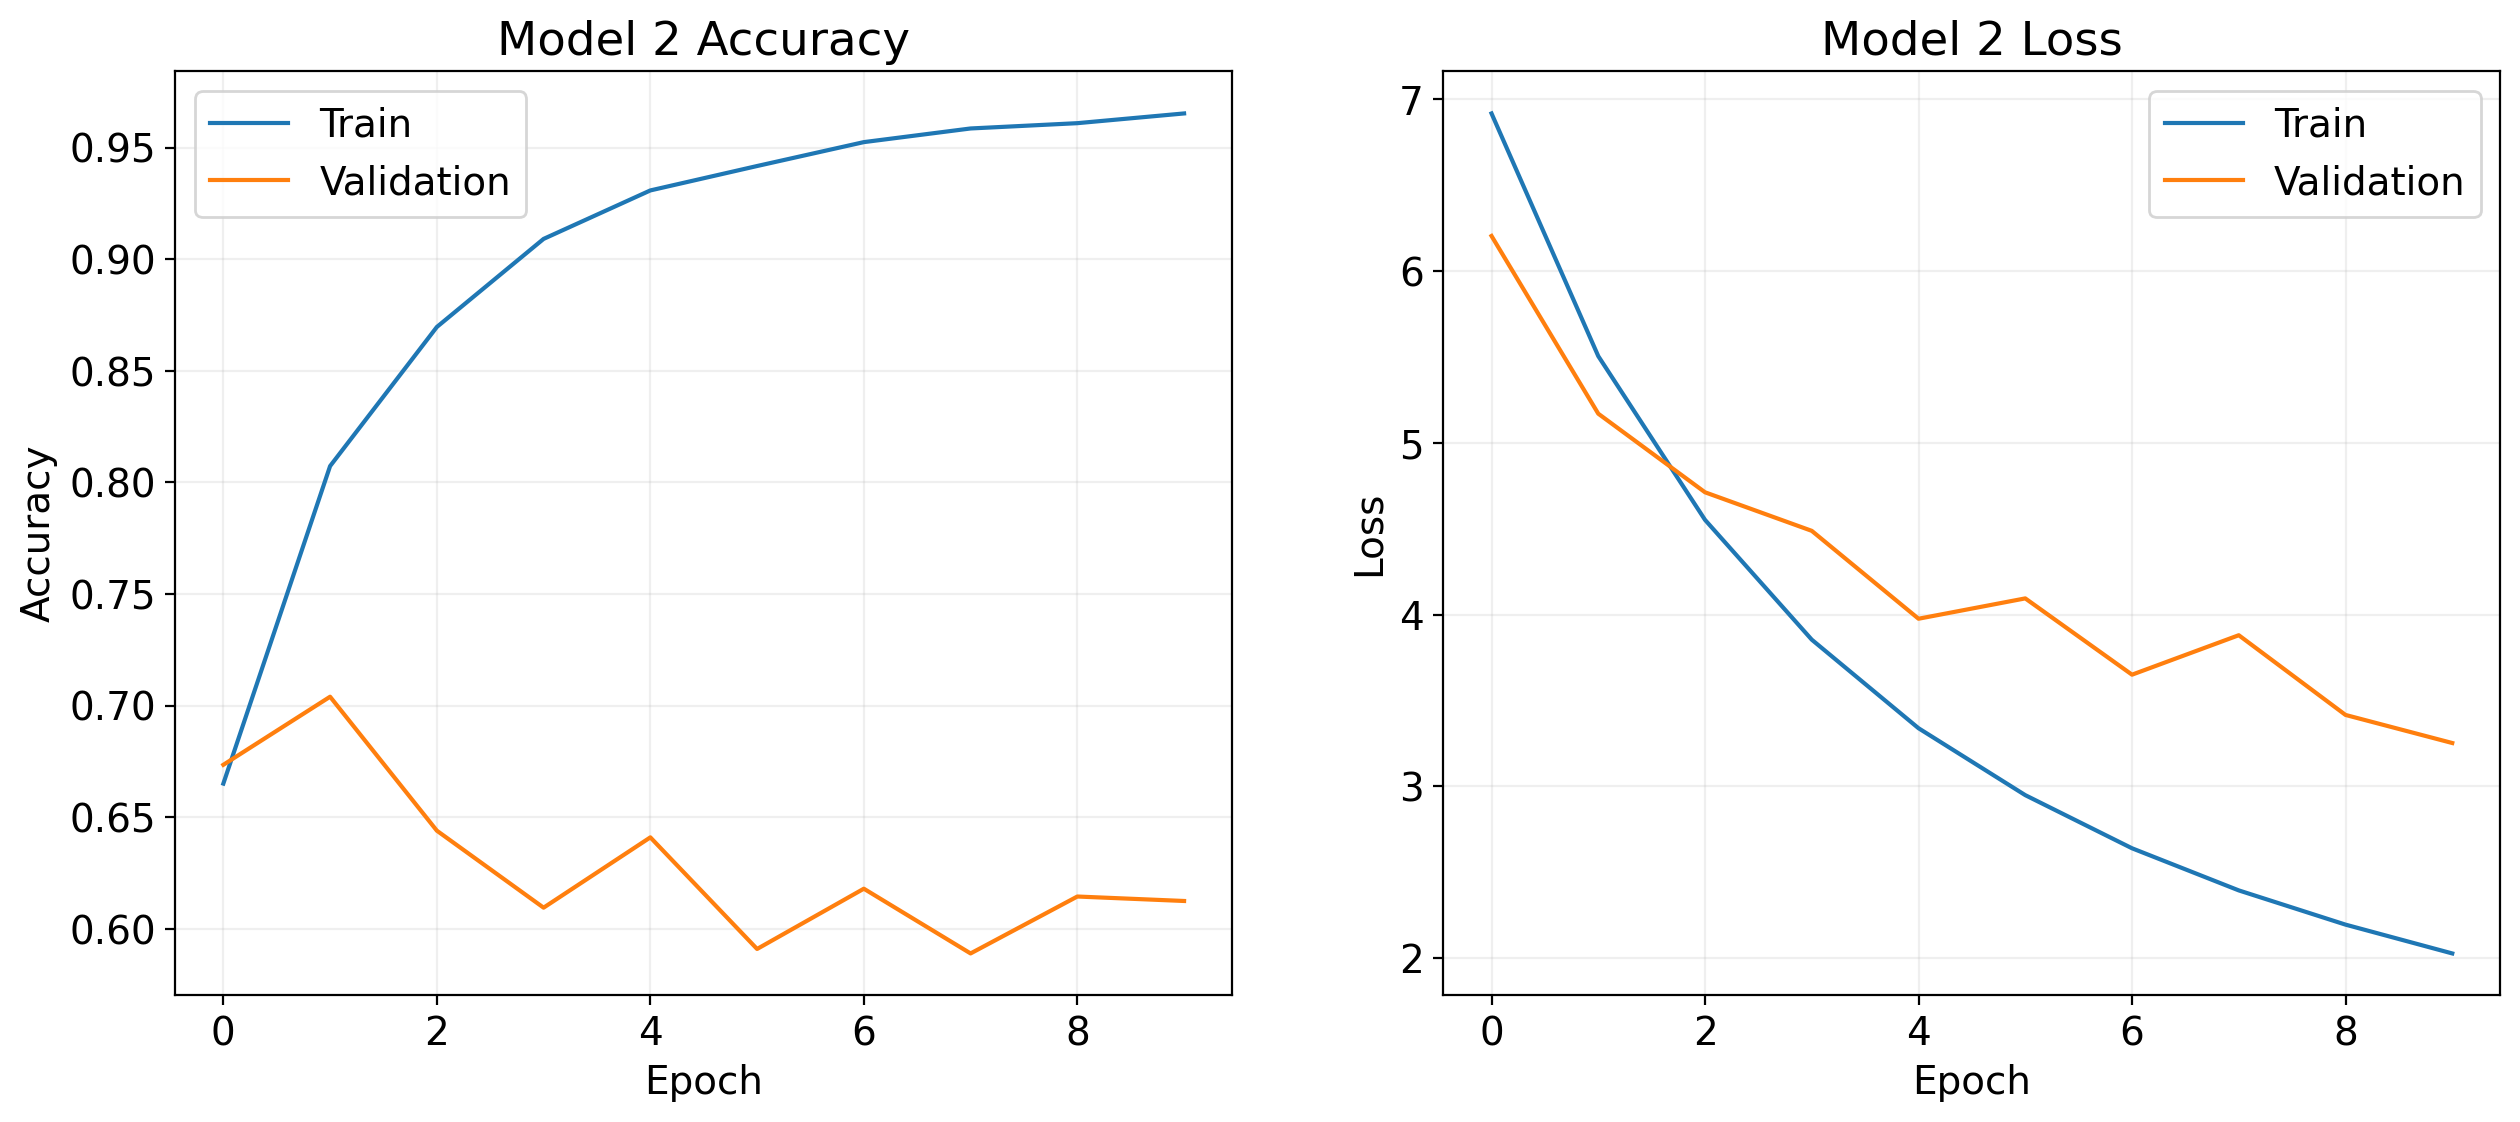

In [864]:
 _, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history1.history['accuracy'])
ax[0].plot(history1.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history1.history['loss'])
ax[1].plot(history1.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

### Accuracy of Model at epoch 2 is considered and it's training accuracy is 70 % and testing accuracy is 80%